## Описание проекта, загрузка данных.

### Введение
______
**Название проекта**  

Прогноз уровня удовлетворённости и оттока сотрудников для оптимизации управления персоналом в компании
_____

**Цель исследования**  

Построить две модели, которые предскажут уровень удовлетворённости сотрудника работой в компании и возможное событие увольнения сотрудника из компании при заданных уровнях метрик, на основе данных заказчика
_______
**Задачи исследования**

*Задача 1: предсказание уровня удовлетворённости сотрудника:*
- Провести необходимую предобработку трех датасетов с данными о сотрудниках компании. 
- Провести исследовательский анализ данных с учетом их типа
- Провести корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования, сделать выводы о мультиколлинеарности
- С использованием пайплайнов обработать количественные и категориальные признаки 
- Обучить минимум 2 модели: линейную и дерево решений. Для каждой из них подобрать гиперпараметры
- Выбрать лучшую модель на основе метрики `SMAPE`
- Сделайть выводы о том, какая модель справилась лучше и почему

*Задача 2: предсказание увольнения сотрудника из компании:*
- Провести необходимую предобработку двух датасетов с данными о сотрудниках компании. 
- Провести исследовательский анализ данных с учетом их типа
- Составить портрет «уволившегося сотрудника».
- Визуализировать и сравнить распределения признака удовлетворённости сотрудника для ушедших и оставшихся сотрудников.
- С использованием пайплайнов обработать количественные и категориальные признаки 
- Обучить минимум 3 модели c подбором гиперпараметров
- Выбрать лучшую модель на основе метрики `ROC-AUC`
- Сделайть выводы о том, какая модель справилась лучше и почему

_____
**Исходные данные**  

Имеются данные, представленные в виде нескольких датасетов и разбитые на тренировочную, тестовую выборки и отдельно целевые признаки, которые содержат следующую информацию:

- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
_________
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак №1;
- `quit` — увольнение сотрудника из компании, целевой признак №2

### Установка и импорт библиотек

!pip install shap -q
!pip install --upgrade numba -q
!pip install --upgrade seaborn -q
!pip install --upgrade shap -q
!pip install -U scikit-learn -q
!pip install phik -q
!pip install optuna-integration -q

In [479]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import os
import phik
import math
import shap
import warnings
import re
import optuna

from phik import phik_matrix
from phik.report import plot_correlation_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from optuna import distributions
from optuna.distributions import CategoricalDistribution
from optuna.integration import OptunaSearchCV
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    OrdinalEncoder, 
    RobustScaler,
    LabelEncoder
)
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    make_scorer
)

In [480]:
# системные настройки
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

In [481]:
# объявление констант
RANDOM_STATE = 42

### Объявление функций

In [484]:
# функция для краткого обзора датасетов
def view_df(df):
    display(df.head()) 
    display(df.info()) 
    display(df.columns) 

In [485]:
# функция для описания непрерывных признаков при статистическом анализе
def cont_plot(df, list_col):
    for name in list_col:
        i = 1
        plt.figure(figsize=(12, 4))
        plt.suptitle(f'Гистограмма и диаграмма размаха признака - {name}', 
                     fontsize = 13, fontweight='bold')
    
        plt.subplot(i, 2, i) 
        sns.histplot(data=df, x=name, kde=True)
    
        plt.subplot(i, 2, i+1)
        sns.boxplot(data=df, x=name)
    
        plt.tight_layout()
        plt.show();
    
        display(df[name].describe())

In [486]:
# функция для описания дискретных признаков при статистическом анализе
def discr_plot(df, list_col):
    i = 1
    plt.figure(figsize=(12, 4))
    for name in list_col:
        plt.subplot(math.ceil(len(list_col) / 2), 2, i)
        sns.countplot(data=df, x=name)
        plt.ylabel('Количество')
        i +=1

    plt.tight_layout()
    plt.show();

In [487]:
# функция для описания количественных признаков при статистическом анализе 
# в разрезе заданного категориального признака

def num_plot_with_cat(df, list_col, cat, stat, common_norm):
    for name in list_col:
        i = 1
        plt.figure(figsize=(12, 4))
    
        plt.subplot(i, 2, i)
        sns.histplot(data=df, x=name, hue=cat, kde=True, stat=stat, common_norm=common_norm)
    
        plt.subplot(i, 2, i+1)
        sns.boxplot(data=df, x=name, hue=cat)
    
        plt.tight_layout()
        plt.show();
    
        display('Данные по уволившимся сотрудникам:', df.loc[df['quit'] == 'yes', name].describe())
        display('Данные по не уволившимся сотрудникам:', df.loc[df['quit'] == 'no', name].describe())

In [488]:
# функция для описания категориальных признаков при статистическом анализе
def cat_plot(df, list_col):
    i = 1
    plt.figure(figsize=(12, 12))
    for name in list_col:
        plt.subplot(3, 2, i)
        df[name].value_counts().plot.pie(label='', autopct='%1.0f%%', title=name)
        i +=1

    plt.tight_layout()
    plt.show();

In [489]:
# функция для описания категориальных признаков при статистическом анализе
# в разрезе заданного категориального признака
def cat_plot_with_cat(df, list_col, cat, height):
    i = 1
    plt.figure(figsize=(12, height))
    for name in list_col:
        plt.subplot(math.ceil(len(list_col) / 2), 2, i)
        sns.countplot(data=df, x=name, hue=cat)
        plt.ylabel('Количество')
        i +=1

    plt.tight_layout()
    plt.show();

In [490]:
# функция для метрики SMAPE

def smape(y_true, y_pred):
    error = np.abs(y_true - y_pred)
    scale = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(error / scale) * 100

## Задача №1: предсказание уровня удовлетворённости сотрудника

### Загрузка данных

In [494]:
pth1 = r'C:\Ipynb\datasets\train_job_satisfaction_rate.csv'
pth2 = 'C:\\Ipynb\\datasets\\test_features.csv'
pth3 = 'C:\\Ipynb\\datasets\\test_target_job_satisfaction_rate.csv'

if os.path.exists(pth1) & os.path.exists(pth2) & os.path.exists(pth3):
    train_satisf = pd.read_csv(pth1, sep=',')
    test_features = pd.read_csv(pth2, sep=',')
    test_target_satisf = pd.read_csv(pth3, sep=',')
else:
    print('Something is wrong with loading data')

### Общая информация о датасетах

In [497]:
list_df = [train_satisf, test_features, test_target_satisf]

for df in list_df:
    view_df(df)
    print('==================================================================')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate'],
      dtype='object')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary'],
      dtype='object')

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

Index(['id', 'job_satisfaction_rate'], dtype='object')

**Вывод:** загружена и получена общая информация по датасетам. В данных имеется незначительное количество пропусков, в соответствии с заданием пропуски заполним в пайплайне. Названия столбцов соответствуют "змеиному типу". Данные и их тип соответствуют описанию. Более подробный анализ, а также выявление дубликатов, аномальных значений и пр. будут произведены на следующих этапах обработки данных.

##  Предобработка данных

### Обработка дубликатов

#### Обработка неявных дубликатов

In [503]:
print('Уникальные значения в столбцах:\n')
for df in list_df:
    for column in df.select_dtypes(exclude=[np.number]).columns.values:
        print(f'"{column}": {df[column].unique()}')
    print()

Уникальные значения в столбцах:

"dept": ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
"level": ['junior' 'middle' 'sinior' nan]
"workload": ['medium' 'high' 'low']
"last_year_promo": ['no' 'yes']
"last_year_violations": ['no' 'yes']

"dept": ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
"level": ['junior' 'middle' 'sinior' nan]
"workload": ['medium' 'low' 'high' ' ']
"last_year_promo": ['no' 'yes']
"last_year_violations": ['no' 'yes']




In [504]:
print('Количество пропусков в датасетах:')
for df in list_df:
    print(df.isna().sum().sum())

print('\nКоличество пробелов в датасете test_features:', 
      len(test_features.query('dept == " " | workload == " "')))

Количество пропусков в датасетах:
10
3
0

Количество пробелов в датасете test_features: 2


В данных имеются пропуски и знаки пробела, заполним на этапе пайплайна

In [506]:
# заменим некорректное sinior на senior
for df in list_df[:2]:
    df['level'] = df['level'].replace('sinior', 'senior')

#### Обработка явных дубликатов

In [508]:
for df in list_df[:2]:
    print(df.duplicated().sum())

0
0


**Вывод:** по результатам предобработки данных заменили некорректное наименование должности, явные и неявные дубликаты отсутствуют, выявленные в данных пропуски и знаки пробела будут заполнены в соответствии с заданием на этапе пайплайна

## Исследовательский анализ данных

### Проведение статистического анализа признаков датасета `train_satisf`

Выделим количественные и категориальные признаки

In [514]:
num_col_train_satisf = train_satisf.iloc[:, 1:].select_dtypes(include='number').columns.tolist()
cat_col_train_satisf = train_satisf.select_dtypes(exclude='number').columns.tolist()
len(num_col_train_satisf + cat_col_train_satisf)

9

In [515]:
# непрерывные признаки
cont_col_train_satisf = num_col_train_satisf[2:]
cont_col_train_satisf

['salary', 'job_satisfaction_rate']

In [516]:
# дискретные признаки
discr_col_train_satisf = num_col_train_satisf[:2]
discr_col_train_satisf

['employment_years', 'supervisor_evaluation']

#### Cтатистический анализ непрерывных признаков

Для описания непрерывных признаков используем гистограмму и диаграмму размаха

In [519]:
# функция для описания непрерывных признаков при статистическом анализе
def cont_plot(df, list_col):
    for name in list_col:
        i = 1
        plt.figure(figsize=(12, 4))
        plt.suptitle(f'Гистограмма и диаграмма размаха признака - {name}', 
                     fontsize = 13, fontweight='bold')
    
        plt.subplot(i, 2, i) 
        sns.histplot(data=df, x=name, kde=True)
    
        plt.subplot(i, 2, i+1)
        sns.boxplot(data=df, x=name)
    
        plt.tight_layout()
        plt.show();
    
        display(df[name].describe())

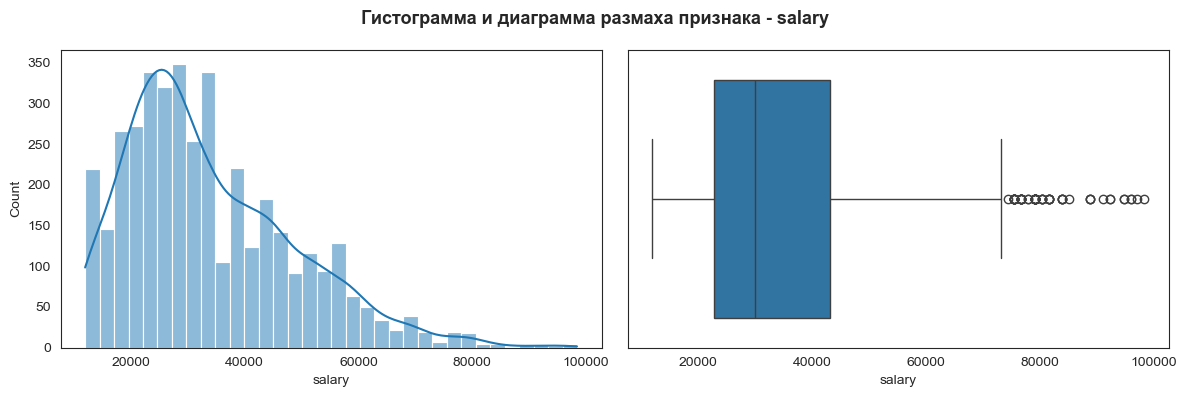

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64

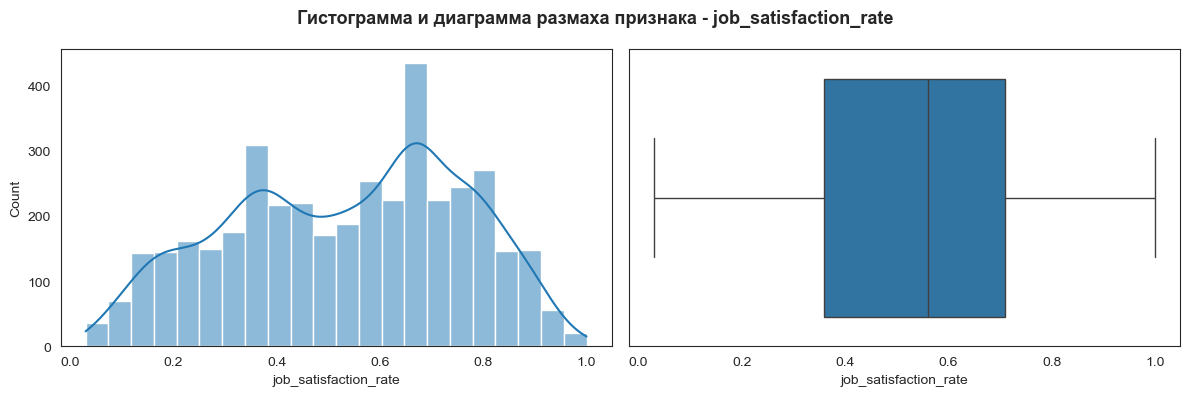

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

In [520]:
# воспользуемся для анализа функцией cont_plot
cont_plot(train_satisf, cont_col_train_satisf)

#### Cтатистический анализ дискретных признаков

Для описания дискретных признаков используем столбчатую диаграмму

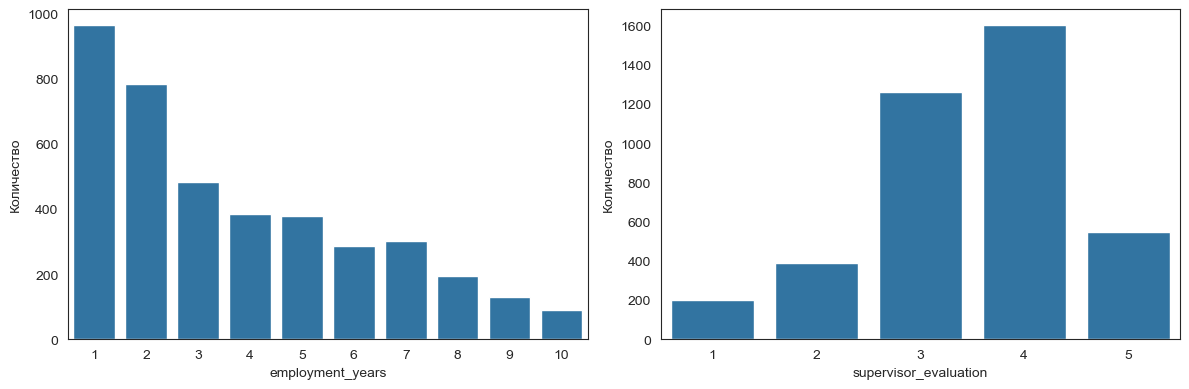

In [526]:
# воспользуемся для анализа функцией discr_plot
discr_plot(train_satisf, discr_col_train_satisf)

Из диаграмм и таблиц видно, что серьезных выбросов в количественных признаках не наблюдается. Целевой признак `job_satisfaction_rate` имеет распределение близкое к нормальному. Остальные признаки  имеют явно ненормальное распределение: смещение вершин к границам диапазона, пропуски и т.д., учтем это в дальнейшем при выборе критерия корреляции. По признаку `salary` имеются редкие значения зарплаты свыше "75 000".  Только по `job_satisfaction_rate` среднее значение близко к медианныму значению.

#### Cтатистический анализ категориальных признаков

Используем для описания категориальных признаков круговые диаграммы

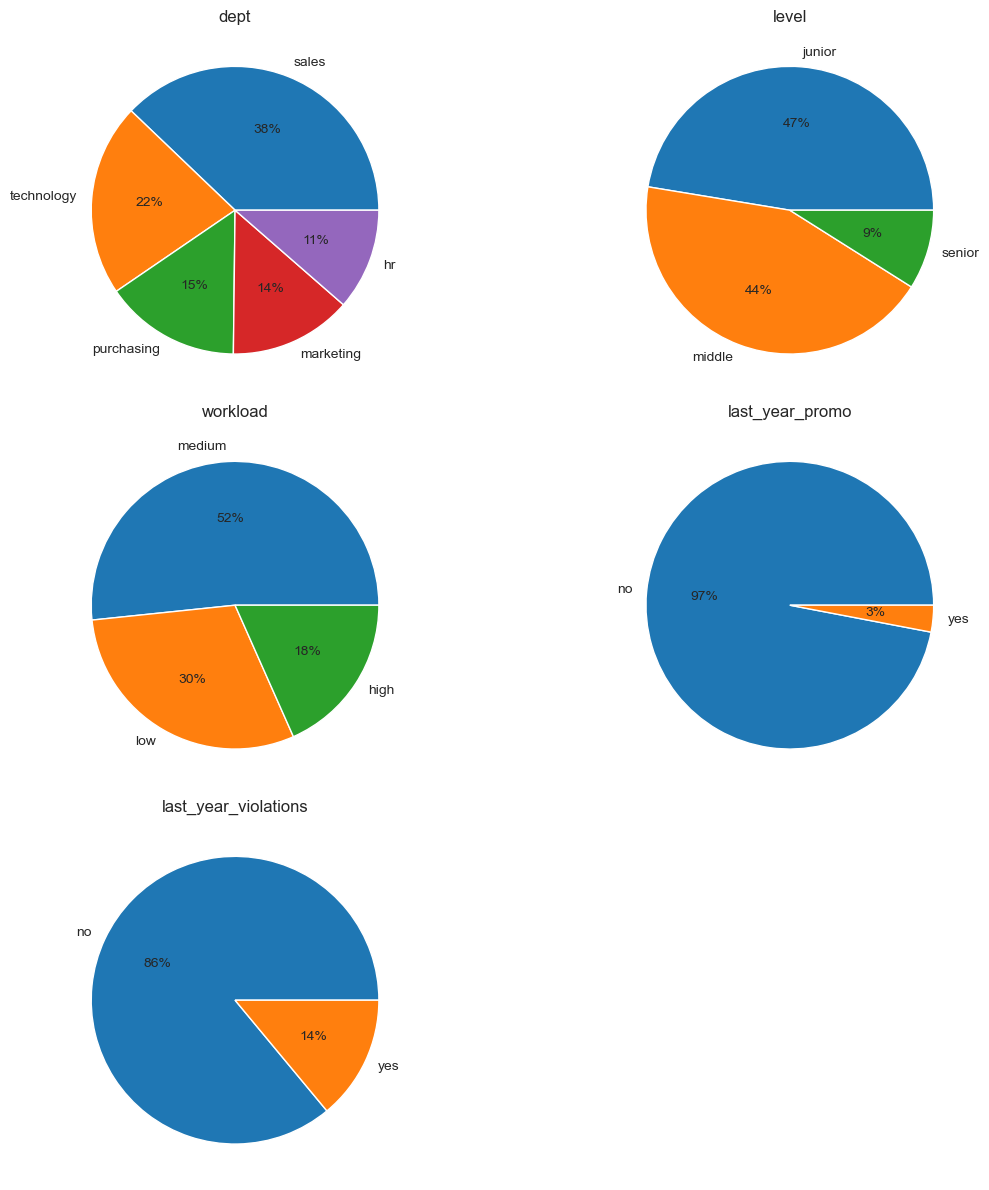

In [530]:
# воспользуемся для анализа функцией cat_plot
cat_plot(train_satisf, cat_col_train_satisf)

Из диаграмм получаем следующую информацию о сотрудниках:
- большинство работает в продажах, затем немногим менее, чем в раза по количеству идут инженеры, на обе групы приходится 60% от общего количества
- 90% должностных позиций приходится на `junior` и `middle`, оставшиеся 10% - на `senior`
- половина сотрудников имеет среднюю загрузку
- только у 3% сотрудников было повышение за последний год
- 14% сотрудников нарушали трудовой договор за последний год

### Проведение статистического анализа признаков датасета *test_features и test_target_satisf*

Выделим количественные и категориальные признаки

In [534]:
num_col_test_features = test_features.iloc[:, 1:].select_dtypes(include='number').columns.tolist()
cat_col_test_features = test_features.select_dtypes(exclude='number').columns.tolist()
len(num_col_test_features + cat_col_test_features)

8

In [535]:
# непрерывные признаки
cont_col_test_features = num_col_test_features[2:]
cont_col_test_features

['salary']

In [536]:
# дискретные признаки
discr_col_test_features = num_col_test_features[:2]
discr_col_test_features

['employment_years', 'supervisor_evaluation']

#### Cтатистический анализ непрерывных признаков

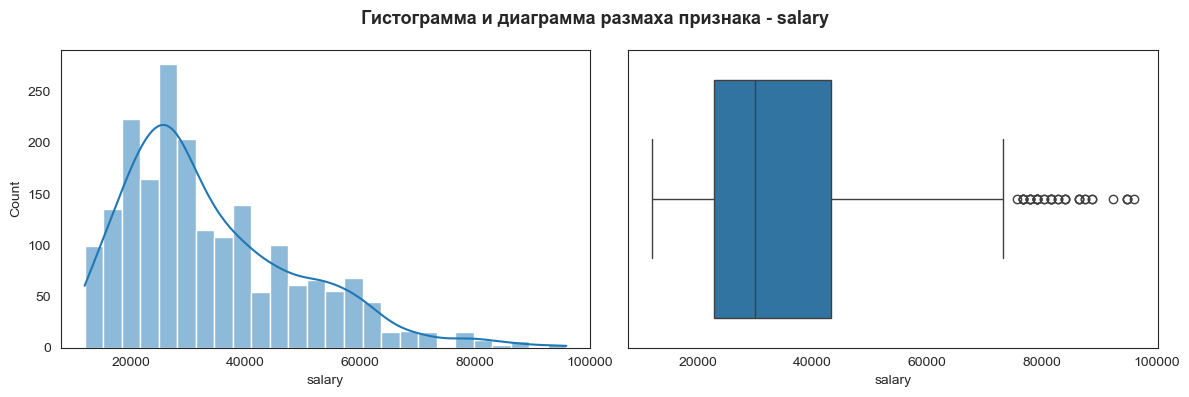

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

In [538]:
# воспользуемся для анализа функцией cont_plot
cont_plot(test_features, cont_col_test_features)

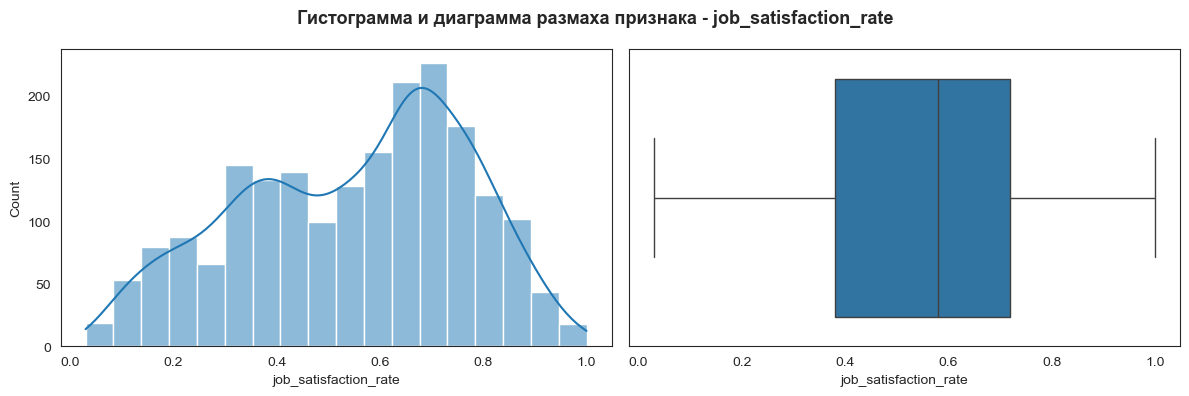

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64

In [539]:
cont_plot(test_target_satisf, ['job_satisfaction_rate'])

#### Cтатистический анализ дискретных признаков

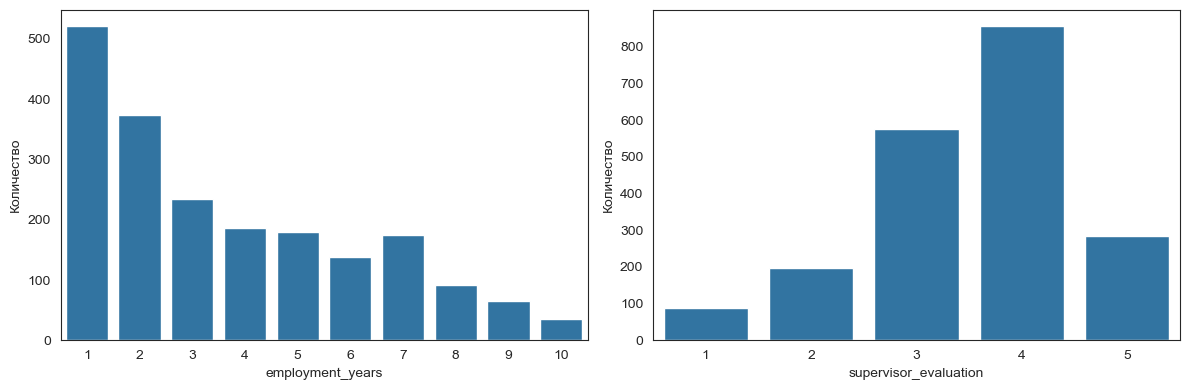

In [541]:
# воспользуемся для анализа функцией discr_plot
discr_plot(test_features, discr_col_test_features)

Из диаграмм и таблиц видно, что распределения признаков в тестовой выборке схожи с тренировочной, серьезных выбросов в количественных признаках не наблюдается. Целевой признак `job_satisfaction_rate` имеет распределение близкое к нормальному. Остальные признаки  имеют явно ненормальное распределение: смещение вершин к границам диапазона, пропуски и т.д. По признаку `salary` имеются редкие значения зарплаты свыше "75 000".  Только по `job_satisfaction_rate` среднее значение близко к медианному значению.

#### Cтатистический анализ категориальных признаков

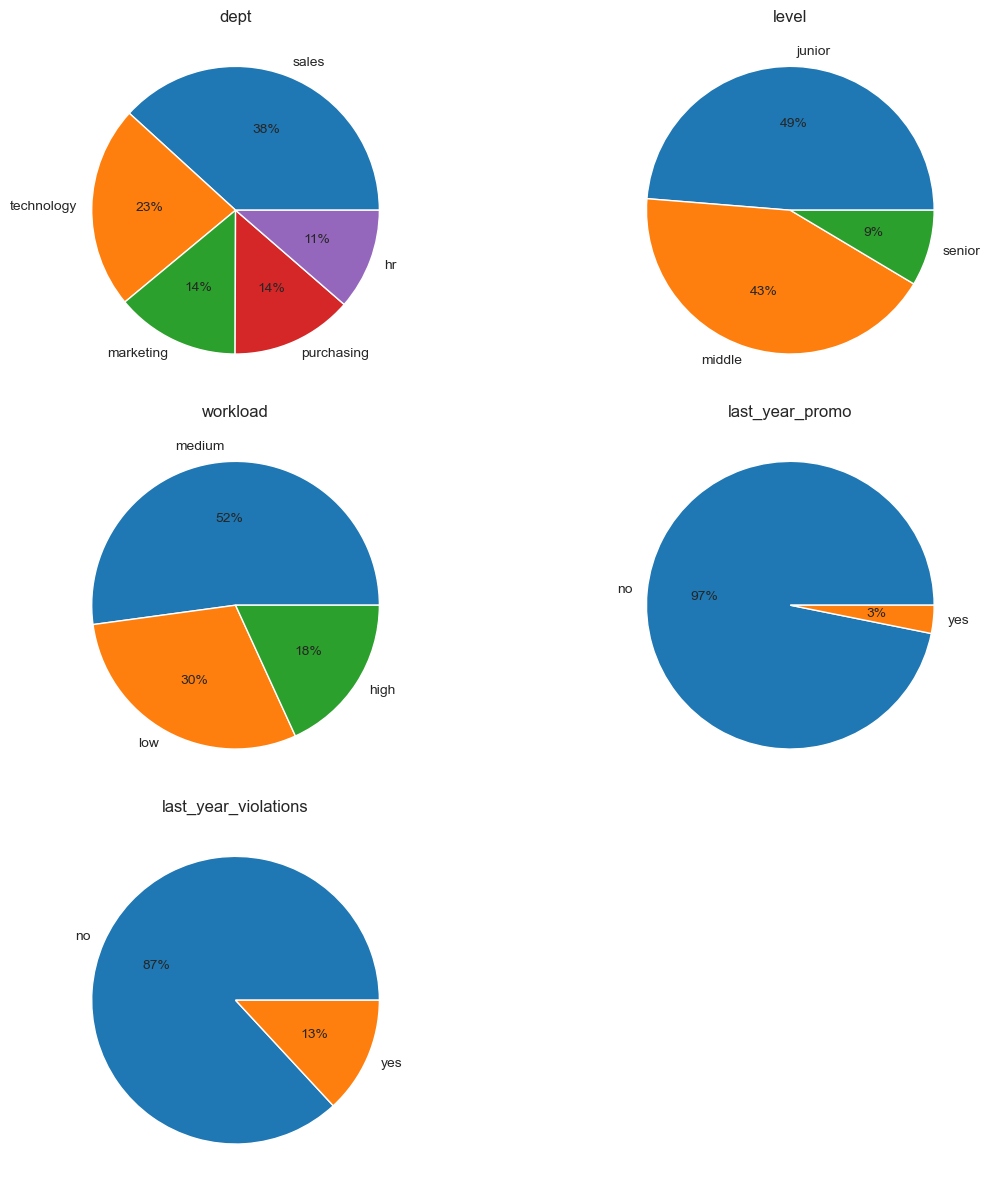

In [544]:
# воспользуемся для анализа функцией cat_plot
cat_plot(test_features.query('~(dept == " " | workload == " ")'), cat_col_test_features)

Здесь также отметим, что соотношения между группами, представленными в признаках, также схожи в тестовой и тренировочной выборках, отметим отличия:
- доли закупщиков и маркетологов выровнялись
- незначительно увеличилась доля `junior` с 47 до 49%
- незначительно до 13% снизилась доля сотрудников, нарушавших трудовой договор за последний год

Таким образом, структура, соотношения, распределения в тренировочной и тестовой выборках схожи

## Корреляционный анализ

### Рассчет коэффициентов корреляции для тренировочной выборки

В связи с тем, что не все признаки распределены нормально, для корреляционного анализа используем матрицу Phik, которая устойчива к ненормальному распределению, позволяет учитывать нелинейные зависимости и работает с различными типами признаков

In [550]:
train_satisf = train_satisf.set_index('id')

In [551]:
# построим матрицу корреляций Фи
interval_cols = ['salary', 'job_satisfaction_rate']

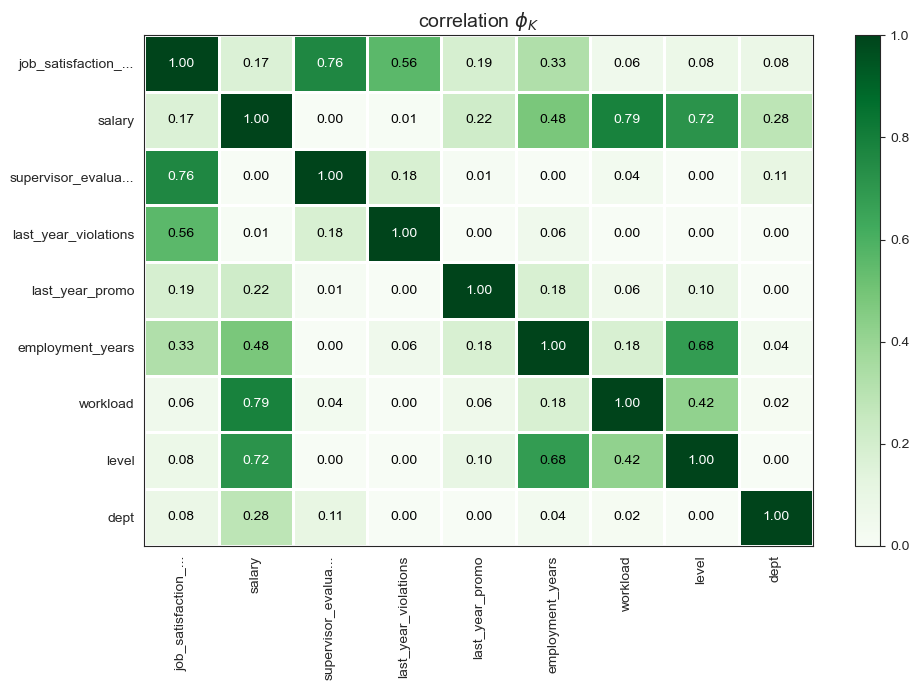

In [555]:
phik_overview = phik_matrix(train_satisf, interval_cols=interval_cols) 

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1,
    figsize=(10, 7)
) 

**Вывод:** из анализа матрицы видно, что мультиколлинеарность в данных отсутствует, при этом у целевого признака `job_satisfaction_rate` имеется:
- высокая теснота связи с признаком `supervisor_evaluation` и заметная теснота связи с признаком `last_year_violations`, таким образом оценка качества работы сотрудника, которую дал руководитель , и которая в т.ч. показывает отношение руководителя к работнику, а также факты нарушения сотрудником трудовой договора, имеют тесную связь с уровнем довлетворённости сотрудника

По другим признакам наблюдается:
- высокая теснота связи между параметрами `salary` c `workload` и `level`, а также умереннная с `employment_years`, т.е связь между уровнем зарплаты и загрузкой сотрудника на работе и уровнем его должности
- высокая теснота связи между параметрами `employment_years` и `level`, что также логично с точки зрения развития и роста сотрудника с течением отработанного времени. 

По остальным признакам наблюдается по большей части слабая связь или ее отсутствие

## Подготовка данных и обучение моделей

### Подготовка данных

#### Подготовка тренировочных данных

Проверим наличие неявных дубликатов в тренировочной выборке без учета признака `id`, т.е среди тех признаков, которые будут использоваться для обучения модели 

In [565]:
print(train_satisf.shape)
train_satisf.duplicated().sum()

(4000, 9)


245

Имеем 245 дубликатов, которые не несут новой информации, т.е. излишне забивают собой пространство данных, соответственно избыточно перегружают модель и возможно могут навредить обучению модели. Удалим дубликаты

In [567]:
train_satisf = train_satisf.drop_duplicates()
train_satisf.shape

(3755, 9)

#### Подготовка тестовых данных

В связи с тем, что тестовые входные признаки и целевой признак былы получены раздельно, необходимо привести их к единому порядку. Объединим их по `id` и заново выделим целевой признак.

In [571]:
# пропуски в исходном датасете test_features до объедиения
test_features.query('dept.isna() | level.isna()')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
312,471990,sales,NaN,low,1,no,no,3,12000
1196,832342,NaN,junior,medium,1,no,no,4,28800


In [572]:
# объединим тестовые входные признаки и целевой признак 
test_features = test_features.set_index('id')
test_target_satisf = test_target_satisf.set_index('id')

test_satisf = test_features.join(test_target_satisf, how='inner')

display(test_satisf.shape)
test_satisf.isna().sum()

(2000, 9)

dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [574]:
test_satisf.query('dept.isna() | level.isna()')

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
609865,NaN,junior,medium,1,no,no,1,20400,0.12
471990,sales,NaN,low,1,no,no,3,12000,0.17
832342,NaN,junior,medium,1,no,no,4,28800,0.61


Размерность датасета после объединения и пропуски соответствуют ожиданиям

#### Рассчет коэффициентов корреляции для тестовой выборки

In [577]:
interval_cols = ['salary', 'job_satisfaction_rate']
interval_cols

['salary', 'job_satisfaction_rate']

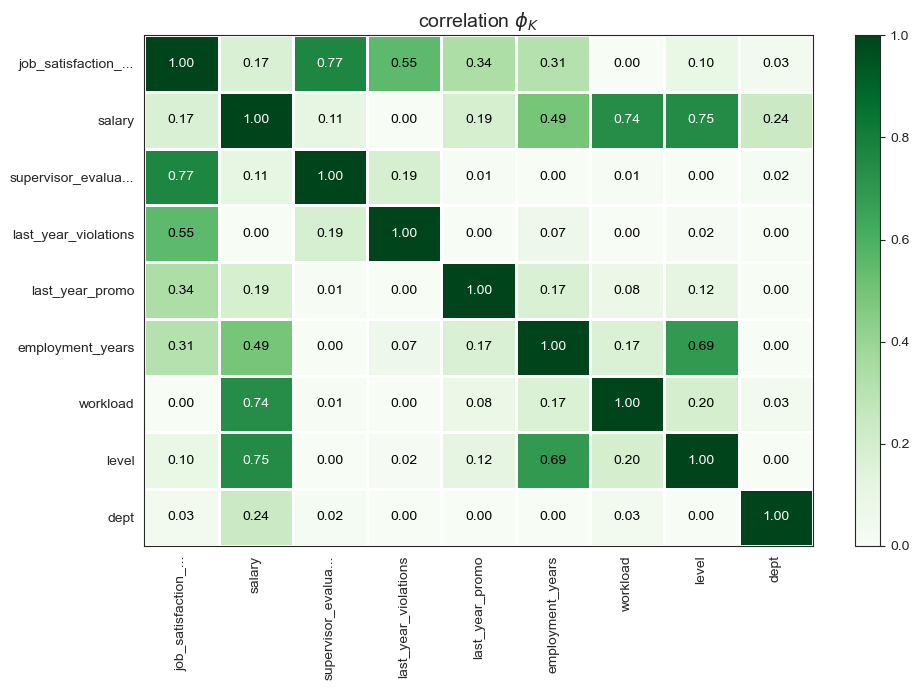

In [578]:
phik_overview = phik_matrix(test_satisf, interval_cols=interval_cols) 

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1,
    figsize=(10, 7)
) 

**Вывод:** из анализа матрицы видно, что мультиколлинеарность в данных отсутствует. Коэффициенты корреляции аналогичны соответствующим коэффициентам на тренировочной выборке, значения отличаются несущественно, разница в пределах 0.03. Ожидаем, что оценка модели, полученная на `test` выборке, будет корректной.

### Настройки подбора модели

Для подбора модели будем использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров `RandomizedSearchCV`. Выбор лучшей модели будет осуществляться на основе метрики — `SMAPE`

В рамках пайплайна используются следующие инструменты:    

для кодирования категориальных признаков:
- OneHotEncoder, OrdinalEncoder  

для масштабирования количественных признаков:
- StandardScaler, MinMaxScaler, RobustScaler, без масштабирования

типы методов:
- LinearRegression, Ridge, DecisionTreeRegressor со своими настройками гиперпараметров

### Обучение и выбор лучшей модели

Настроим метрику

In [584]:
smape_score = make_scorer(
    smape,
    greater_is_better=False)

In [585]:
# подготовим тренировочную и тестовую выборки
X_train = train_satisf.drop(['job_satisfaction_rate'], axis=1)
y_train = train_satisf['job_satisfaction_rate']
X_test = test_satisf.drop(['job_satisfaction_rate'], axis=1)
y_test = test_satisf['job_satisfaction_rate']

# создаём списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

# создаём пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high'],
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', None)
])

In [587]:
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 20),
        'models__min_samples_leaf': range(3, 10),
        'models__min_samples_split': range(3, 10) 
    },
    
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'models__fit_intercept': [True, False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели Ridge()
    {
        'models': [Ridge(random_state=RANDOM_STATE)],
        'models__alpha': [0.001, 0.01, 0.03, 0.05, 0.08, 1, 5, 10, 50, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

In [591]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_score,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=30
)
randomized_search.fit(X_train, y_train)

display('Лучшая модель и её параметры:', randomized_search.best_params_)
print ('Метрика SMAPE, полученная с помощью кросс-валидации:', randomized_search.best_score_ * -1)

'Лучшая модель и её параметры:'

{'models__min_samples_split': 4,
 'models__min_samples_leaf': 3,
 'models__max_depth': 17,
 'models': DecisionTreeRegressor(random_state=42)}

Метрика SMAPE, полученная с помощью кросс-валидации: 15.286365103241152


In [596]:
# рассчитаем прогноз и метрику SMAPE на тестовых данных
y_pred = randomized_search.predict(X_test)
print('метрика SMAPE на тестовых данных:', smape(y_test, y_pred))

метрика SMAPE на тестовых данных: 13.452735672780564


Проверим лучшую модель на адекватность, путем сравнения качества её предсказаний с DummyRegressor

In [598]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)

y_pred_dummy = dummy_regr.predict(X_test)
print('метрика SMAPE на тестовых данных с помощью DummyRegressor:', smape(y_test, y_pred_dummy))

метрика SMAPE на тестовых данных с помощью DummyRegressor: 38.26225790202237


Качество предсказаний лучшей модели значительно выше результатов константной модели

Сохраним результаты работы со всеми моделями в `result`

In [605]:
result = pd.DataFrame(randomized_search.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score').head())

,rank_test_score,param_models,mean_test_score,params
1,1,DecisionTreeRegressor(random_state=42),-15.286365,"{'models__min_samples_split': 4, 'models__min_samples_leaf': 3, 'models__max_depth': 17, 'models': DecisionTreeRegressor(random_state=42)}"
27,2,DecisionTreeRegressor(random_state=42),-15.303544,"{'models__min_samples_split': 6, 'models__min_samples_leaf': 3, 'models__max_depth': 14, 'models': DecisionTreeRegressor(random_state=42)}"
26,3,DecisionTreeRegressor(random_state=42),-15.408845,"{'models__min_samples_split': 8, 'models__min_samples_leaf': 5, 'models__max_depth': 19, 'models': DecisionTreeRegressor(random_state=42)}"
23,4,DecisionTreeRegressor(random_state=42),-15.409061,"{'models__min_samples_split': 9, 'models__min_samples_leaf': 5, 'models__max_depth': 17, 'models': DecisionTreeRegressor(random_state=42)}"
0,5,DecisionTreeRegressor(random_state=42),-15.522851,"{'models__min_samples_split': 5, 'models__min_samples_leaf': 4, 'models__max_depth': 17, 'models': DecisionTreeRegressor(random_state=42)}"


**Вывод:** **Моделью, показавшей наилучшие результаты** на кроссвалидационной выборке, стала `DecisionTreeRegressor` с параметрами: минимальное количество объектов должно быть в узле, чтобы они разделились на классы - 4, минимальное количество объектов в одном листе - 3, глубина дерева - 17

Дерево решений оказалось лучшей моделью по причине наличия нелинейных связей между параметрами, с которыми хуже справляются линейные модели, а также по причине наличия большего количества категориальных признаков, чем количественных, с чем тоже линейные модели справляются не очень хорошо, к таким данным больше подходит дерево решений.

## Анализ важности признаков

In [608]:
# извлечение лучшего пайплайна и модели
pipeline_best_task1 = randomized_search.best_estimator_
model_best_task1 = pipeline_best_task1.named_steps['models']

# извлечем преобразованные названия столбцов и преобразуем X_train, X_test
feature_names = pipeline_best_task1.named_steps['preprocessor'].get_feature_names_out()

X_train_transformed = pipeline_best_task1.named_steps['preprocessor'].transform(X_train)
X_train_transformed = pd.DataFrame(X_train_transformed, columns=feature_names)
display(X_train_transformed.shape)

X_test_transformed = pipeline_best_task1.named_steps['preprocessor'].transform(X_test)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names)
X_test_transformed.shape

(3755, 11)

(2000, 11)

### График важности признаков для модели дерева решений

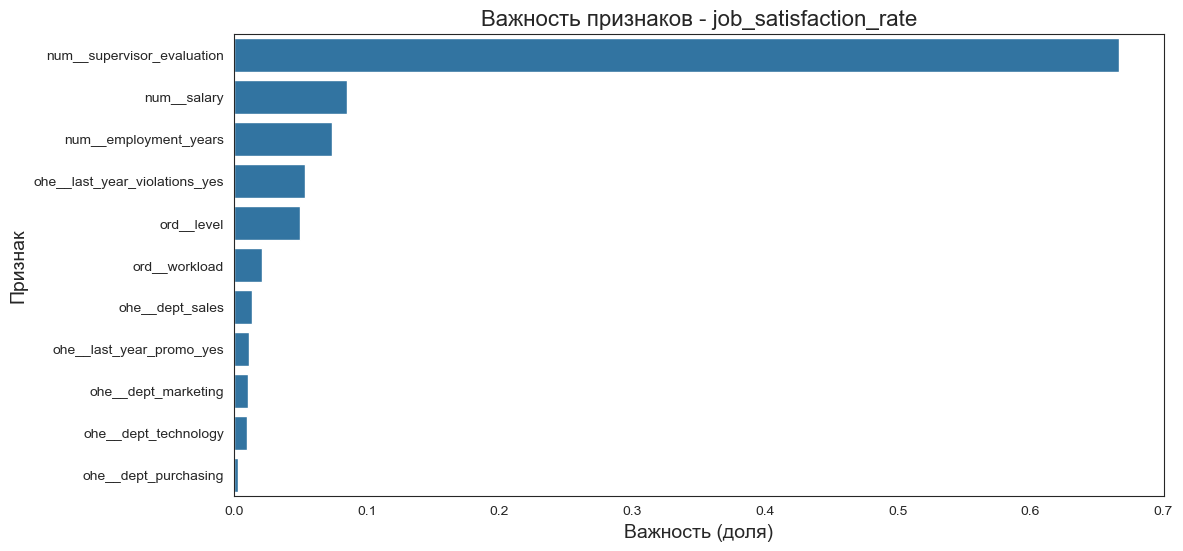

In [610]:
# формируем таблицу важности признаков и сортируем её
feature_importances = pd.DataFrame(
    {
        'Feature': X_train_transformed.columns,
        'Importance': model_best_task1.feature_importances_
    }).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))

ax = sns.barplot(data=feature_importances, x='Importance', y='Feature')

ax.set_title('Важность признаков - job_satisfaction_rate', fontsize=16)
ax.set_xlabel('Важность (доля)', fontsize=14)
ax.set_ylabel('Признак', fontsize=14)

# отображаем график
plt.show()

Анализ важности признаков показывает, что наибольший вклад в предсказание удовлетворённости сотрудника работой в порядке убывания вносят:
- оценка качества работы сотрудника руководителем (наиболее значительный вклад)
- уровень зарплаты
- длительность работы в компании
- факт нарушения сотрудником трудового договора за последний год
- уровень занимаемой должности

### Оценка важности признаков на основе `Permutation importance`

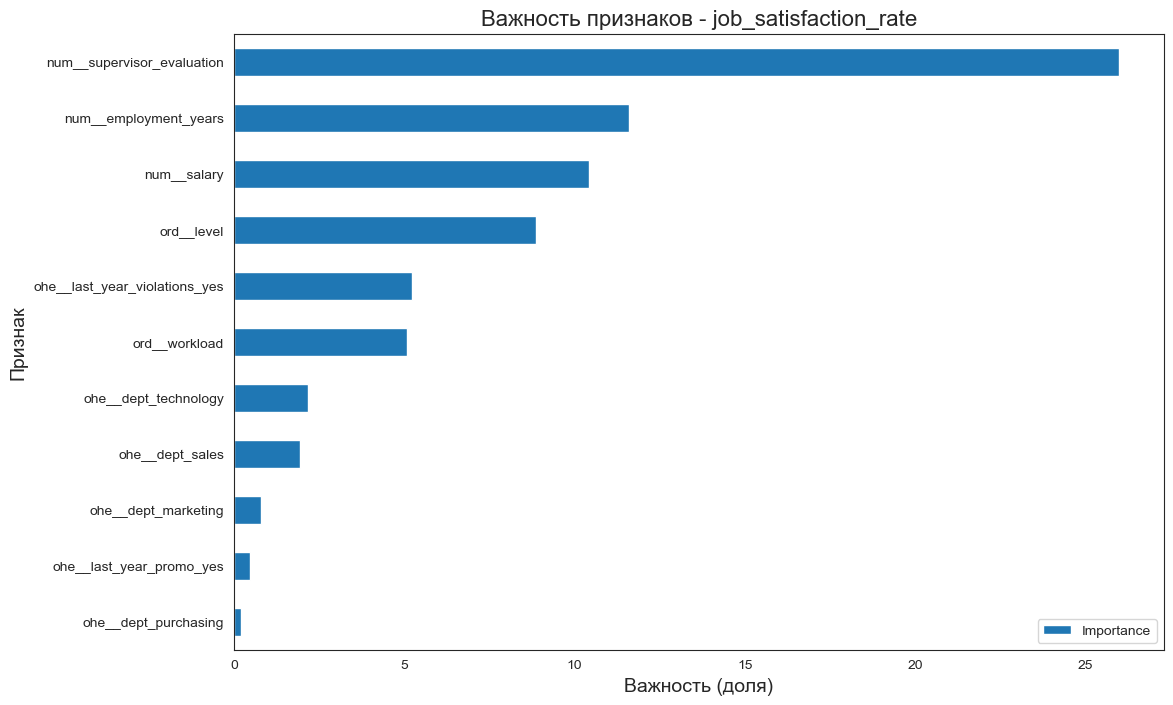

In [613]:
result = permutation_importance(model_best_task1, X_test_transformed, y_test,  scoring = smape_score)

feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': result['importances_mean']})
feature_importance['Importance'] = abs(feature_importance['Importance'])
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(12, 8))
plt.title('Важность признаков - job_satisfaction_rate', fontsize=16)
plt.xlabel('Важность (доля)', fontsize=14)
plt.ylabel('Признак', fontsize=14);

Анализ результатов `permutation importance` показывает, что состав "пятерки" наиболее важных признаков сохраняется с "лидером" - `оценка качества работы сотрудника руководителем `

### Оценка важности признаков на основе `SHAP`

#### Столбчатая диаграмма, отражающая общий вклад признаков в прогнозы модели.

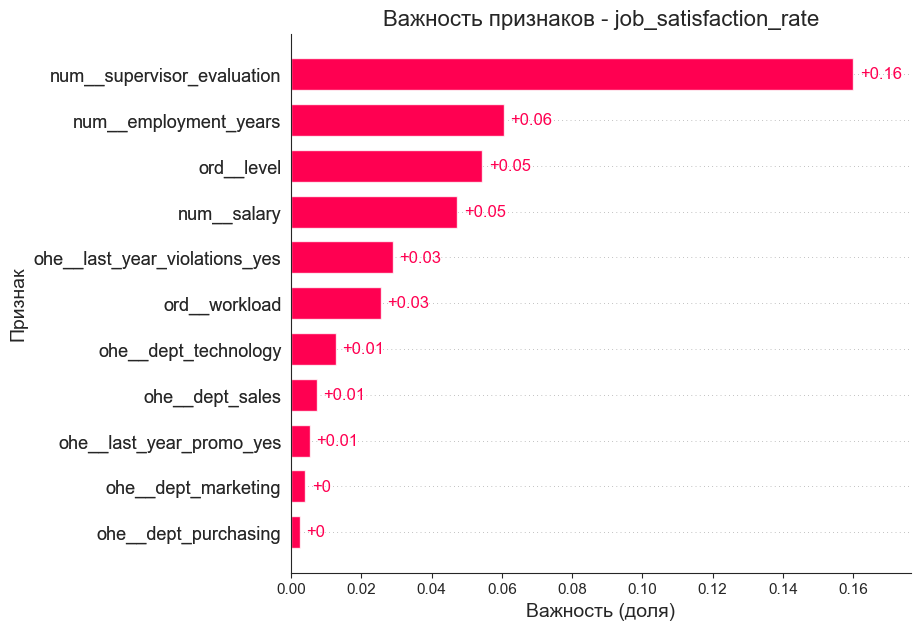

In [620]:
explainer = shap.TreeExplainer(model_best_task1, X_test_transformed)
shap_values = explainer(X_test_transformed)
shap.plots.bar(shap_values, max_display=20,show=False)

plt.title('Важность признаков - job_satisfaction_rate', fontsize=16)
plt.xlabel('Важность (доля)', fontsize=14)
plt.ylabel('Признак', fontsize=14);

#### Диаграмма `beeswarm`, отражающая вклад признаков в каждое предсказание модели.

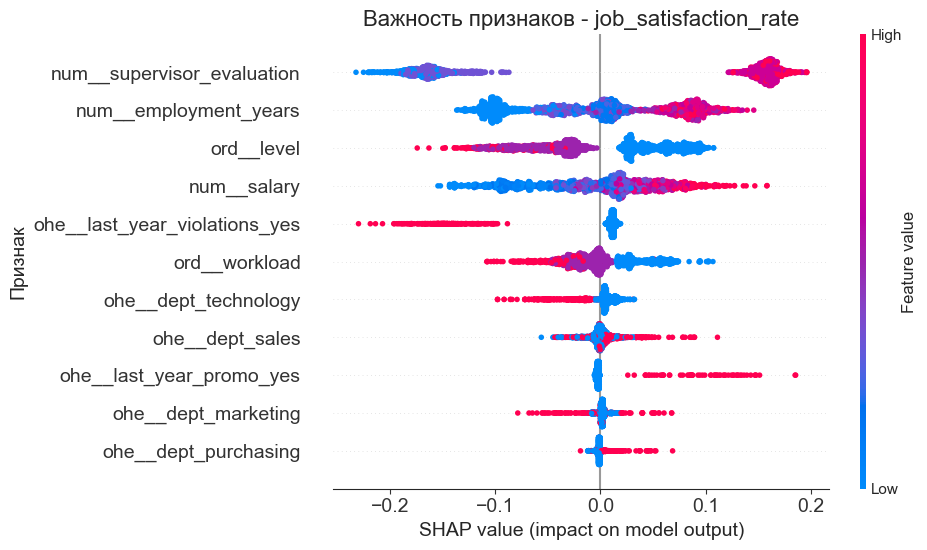

In [622]:
shap.plots.beeswarm(shap_values, max_display=20, show=False)

fig, ax = plt.gcf(), plt.gca()

ax.tick_params(labelsize=14)
ax.set_xlabel("SHAP value (impact on model output)", fontsize=14)
ax.set_ylabel("Признак", fontsize=14)
ax.set_title('Важность признаков - job_satisfaction_rate', fontsize=16)

plt.show()

**Вывод:** на основе представленных графиков можно сделать следующие выводы о значимости признаков для прогнозирования:
1. признаки, мало значимые для модели:
- наименование департамента
- наличие повышения за последний год

2. признаки, сильнее всего влияющие на целевой признак:    
рост или увеличение уровня которых, приводят к увеличению удовлетворённости сотрудника работой:
- оценка качества работы сотрудника руководителем
- длительность работы в компании
- уровень зарплаты    

рост или увеличение уровня которых, приводят к снижению удовлетворённости сотрудника работой:
- уровень занимаемой должности
- факт нарушения сотрудником трудового договора за последний год
- уровень загруженности сотрудника

## Задача №2: предсказание увольнения сотрудника из компании

### Загрузка данных

In [632]:
pth4 = r'C:\Ipynb\datasets\train_quit.csv'
pth5 = r'C:\Ipynb\datasets\test_target_quit.csv'

if os.path.exists(pth4) & os.path.exists(pth5):
    train_quit = pd.read_csv(pth4, sep=',')
    test_target_quit = pd.read_csv(pth5, sep=',')
else:
    print('Something is wrong with loading data')

Входные признаки тестовой выборки те же, что и в прошлой задаче: `test_features`

### Общая информация о датасетах

In [635]:
list_df = [train_quit, test_target_quit]

for df in list_df:
    view_df(df)
    print('==================================================================')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'quit'],
      dtype='object')

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

Index(['id', 'quit'], dtype='object')

**Вывод:** загружена и получена общая информация по датасетам. В данных отсутствуют пропуски. Названия столбцов соответствуют "змеиному типу". Данные и их тип соответствуют описанию. Более подробный анализ, а также выявление дубликатов, аномальных значений и пр. будут произведены на следующих этапах обработки данных.

##  Предобработка данных

### Обработка дубликатов

#### Обработка неявных дубликатов

In [640]:
print('Уникальные значения в столбцах:\n')
for df in list_df:
    for column in df.select_dtypes(exclude=[np.number]).columns.values:
        print(f'"{column}": {df[column].unique()}')
    print()

Уникальные значения в столбцах:

"dept": ['sales' 'purchasing' 'marketing' 'technology' 'hr']
"level": ['middle' 'junior' 'sinior']
"workload": ['high' 'medium' 'low']
"last_year_promo": ['no' 'yes']
"last_year_violations": ['no' 'yes']
"quit": ['no' 'yes']

"quit": ['yes' 'no']



In [641]:
# заменим некорректное sinior на senior
train_quit['level'] = train_quit['level'].replace('sinior', 'senior')

#### Обработка явных дубликатов

In [643]:
train_quit.duplicated().sum()

0

**Вывод:** по результатам предобработки данных заменили некорректное наименование должности, явные и неявные дубликаты отсутствуют.

## Исследовательский анализ данных

### Проведение статистического анализа признаков датасетов "train_quit" и "test_target_quit"

Выделим количественные и категориальные признаки

In [648]:
num_col_train_quit = train_quit.iloc[:, 1:].select_dtypes(include='number').columns.tolist()
cat_col_train_quit = train_quit.select_dtypes(exclude='number').columns.tolist()
len(num_col_train_quit + cat_col_train_quit)

9

In [649]:
# непрерывные признаки
cont_col_train_quit = num_col_train_quit[2:]
cont_col_train_quit

['salary']

In [650]:
# дискретные признаки
discr_col_train_quit = num_col_train_quit[:2]
discr_col_train_quit

['employment_years', 'supervisor_evaluation']

#### Cтатистический анализ непрерывных признаков

Для описания непрерывных признаков используем гистограмму и диаграмму размаха

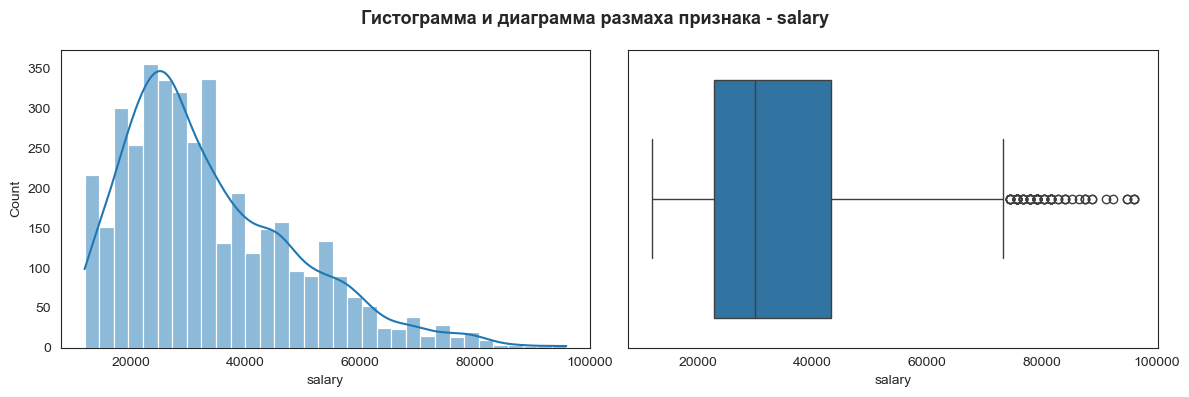

count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

In [653]:
# воспользуемся для анализа функцией cont_plot
cont_plot(train_quit, cont_col_train_quit)

#### Cтатистический анализ дискретных признаков

Для описания дискретных признаков используем столбчатую диаграмму

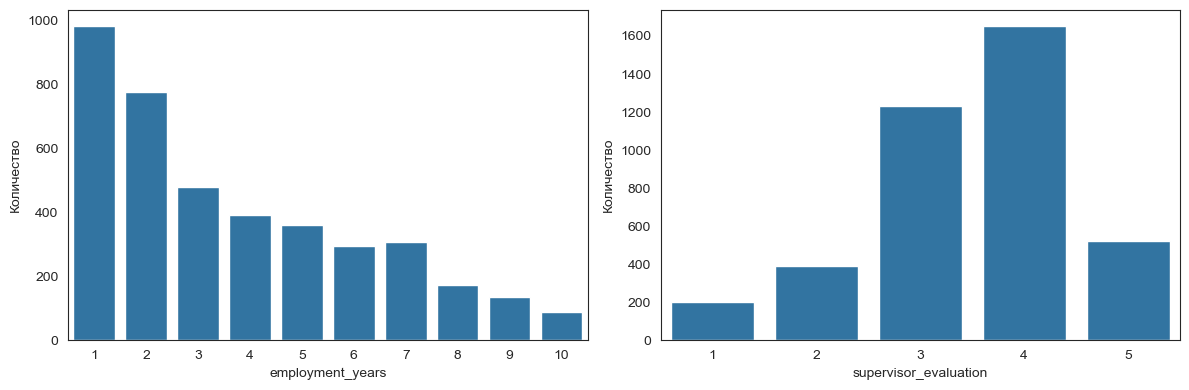

In [656]:
discr_plot(train_quit, discr_col_train_quit)

Из диаграмм и таблиц видно, что серьезных выбросов в количественных признаках не наблюдается. Признаки имеют ненормальное распределение: смещение вершин к границам диапазона, пропуски и т.д., учтем это в дальнейшем при выборе критерия корреляции. По признаку `salary` имеются редкие значения зарплаты свыше приблизительно "73 000". Средние значения признаков заметно отличаются от медианных.

#### Cтатистический анализ категориальных признаков

Используем для описания категориальных признаков круговые диаграммы

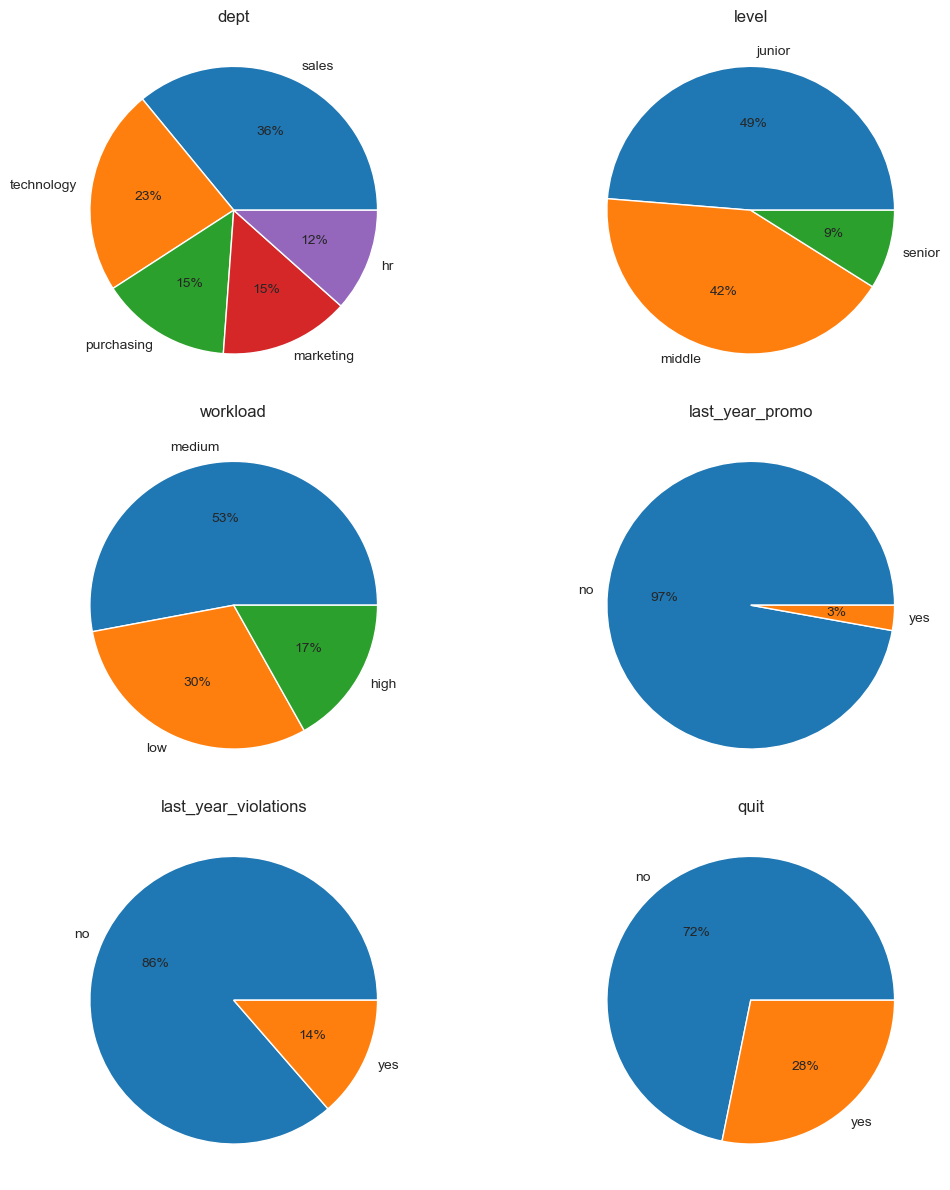

In [660]:
# воспользуемся для анализа функцией cat_plot
cat_plot(train_quit, cat_col_train_quit)

Дополнительно отобразим распределение целевого признака в `test_target_quit`

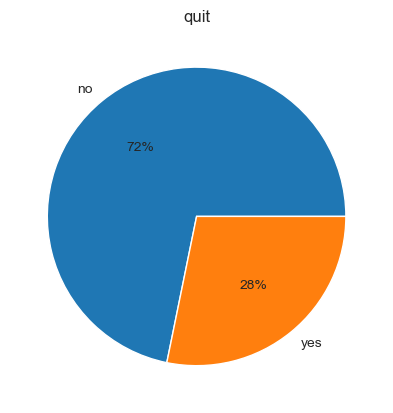

In [662]:
cat_plot(test_target_quit, ['quit'])

Из диаграмм получаем следующую информацию о сотрудниках:
- большинство работает в продажах, примерно четверть составляют инженеры, на обе групы приходится 60% от общего количества
- половины всех должностных позиций приходится на `junior`, 42% составляют `middle`, оставшиеся 9% - `senior`
- более половины сотрудников имеет среднюю загрузку
- только у 3% сотрудников было повышение за последний год
- 14% сотрудников нарушали трудовой договор за последний год
- 28% сотрудников уволилось из компании (это же соотношение наблюдается и в тестовой выборке)

### Описание портрета «уволившегося сотрудника»

Рассмотрим признаки в разрезе уволившихся и оставшихся сотрудников

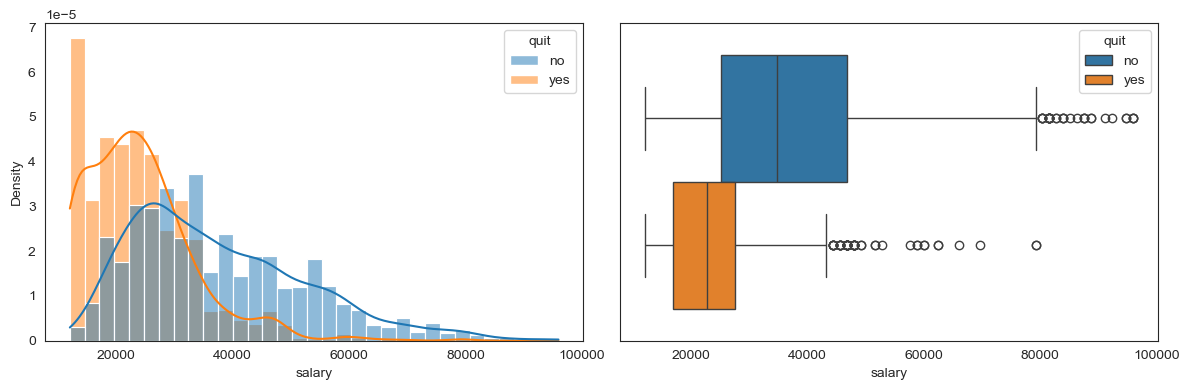

'Данные по уволившимся сотрудникам:'

count     1128.000000
mean     23885.106383
std       9351.599505
min      12000.000000
25%      16800.000000
50%      22800.000000
75%      27600.000000
max      79200.000000
Name: salary, dtype: float64

'Данные по не уволившимся сотрудникам:'

count     2872.000000
mean     37702.228412
std      15218.977339
min      12000.000000
25%      25200.000000
50%      34800.000000
75%      46800.000000
max      96000.000000
Name: salary, dtype: float64

In [666]:
num_plot_with_cat(train_quit, [num_col_train_quit[-1]], 'quit', 'density', False)

Для дискретных и категориальных признаков построим распределения с абсолютными и относительными значениями признаков в разрезе оставшихся и уволившихся сотрудников

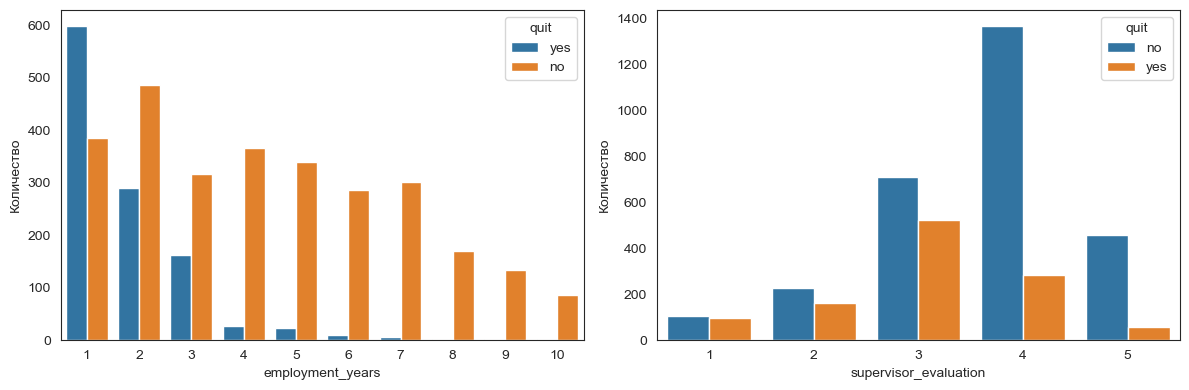

In [668]:
cat_plot_with_cat(train_quit, num_col_train_quit[:-1], 'quit', 4)

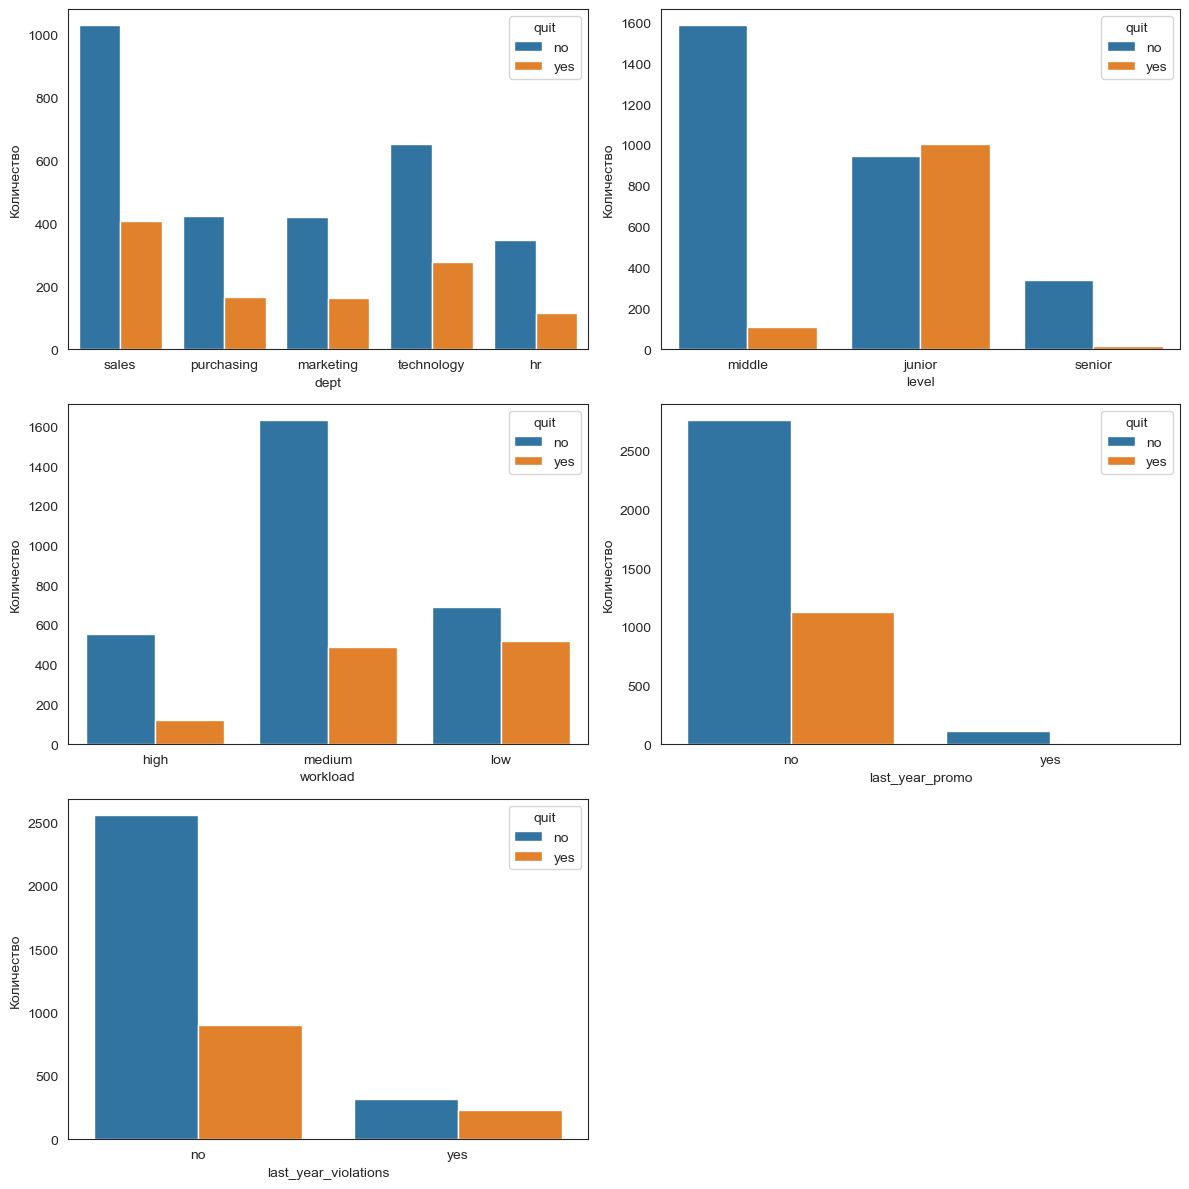

In [669]:
cat_plot_with_cat(train_quit, cat_col_train_quit[:-1], 'quit', 12)

In [670]:
col_train_quit = num_col_train_quit[:-1] + cat_col_train_quit[:-1]

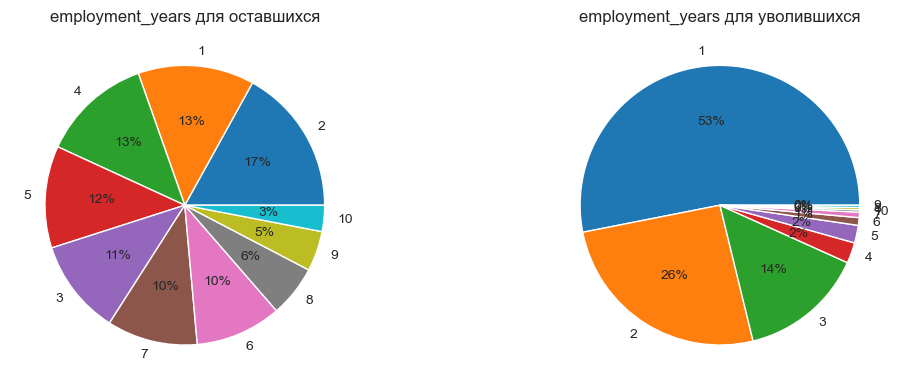

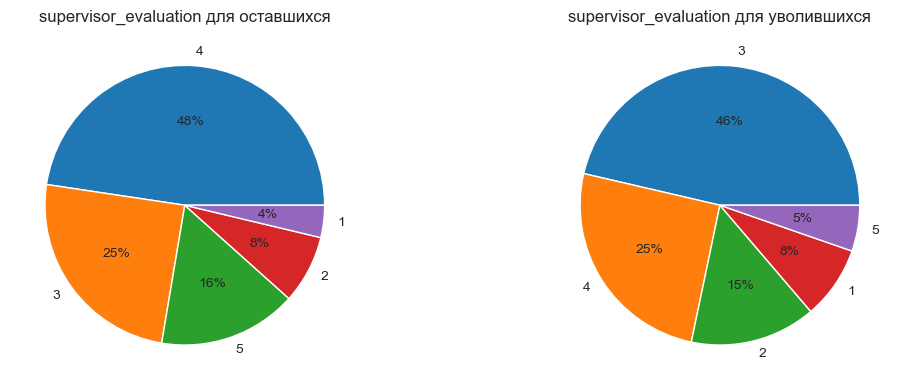

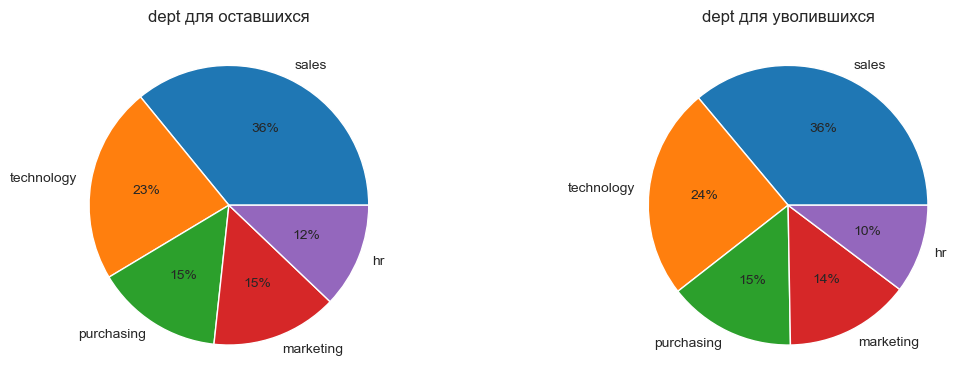

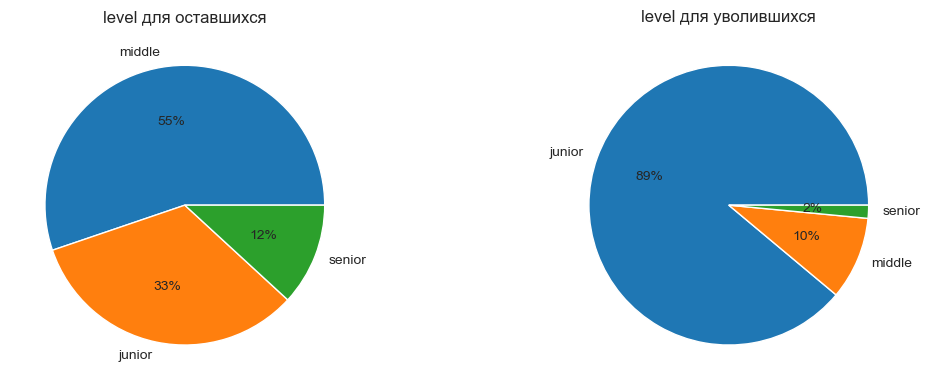

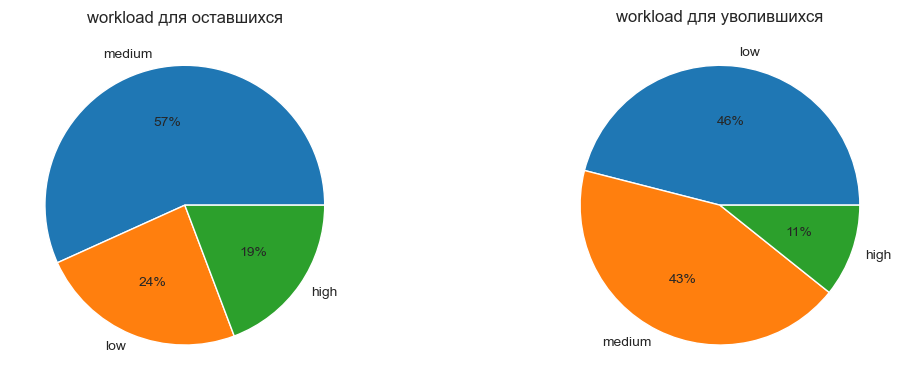

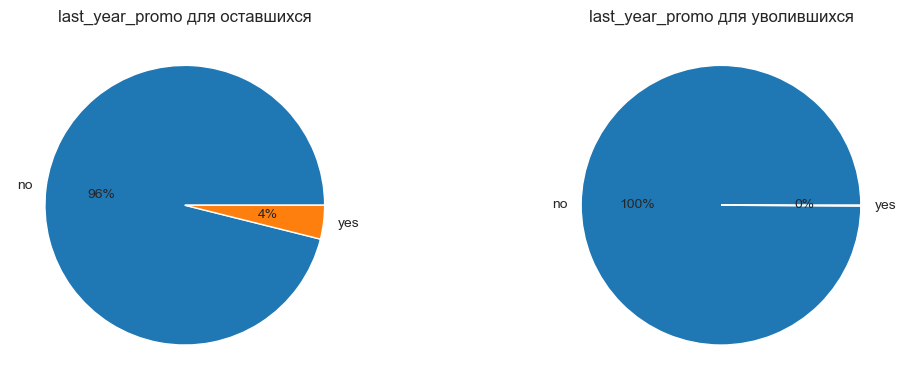

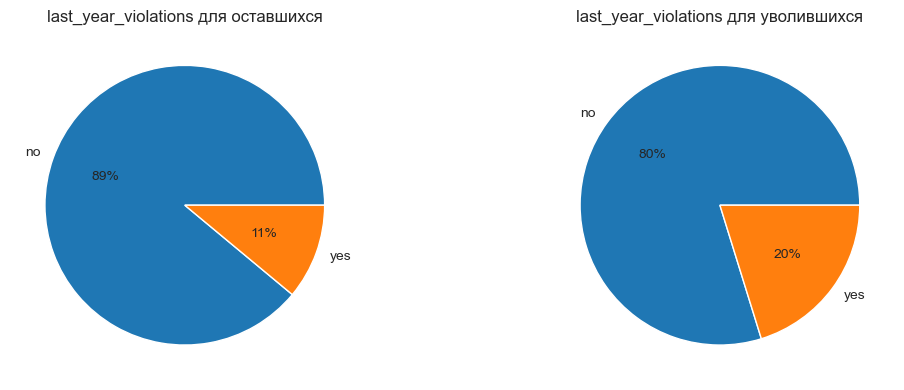

In [671]:
for name in col_train_quit:
    i = 1
    plt.figure(figsize=(12, 4))

    plt.subplot(i, 2, i) 
    train_quit.loc[train_quit['quit'] == 'no', name]\
    .value_counts()\
    .plot.pie(label='', autopct='%1.0f%%', title=f'{name} для оставшихся')

    plt.subplot(i, 2, i+1)
    train_quit.loc[train_quit['quit'] == 'yes', name]\
    .value_counts()\
    .plot.pie(label='', autopct='%1.0f%%', title=f'{name} для уволившихся')

    plt.tight_layout()
    plt.show();

Из анализа признаков можно составить следующую картину по уволимшимся сотрудникам:
- медианное значение зарплаты составляет около 23 000 руб., что на 50% ниже аналогичного значения по не уволимшимся сотрудникам
- более половины проработали до 1 года в компании, еще четверть уволилась в течении второго года работы, т.е сотрудники, которые возможно пришли набраться опыта или поняли, что компания им не подходит, а возможно и работодатель решил, что сотрудник, в силу разных причин не подходит компании, достаточно быстро увольняются. После отработки свыше трех лет факты увольнения уже достаточно редкие.
- почти половина имела оценку `3` качества работы, четверть имела оценку `4`
- около трети работала в отделе продаж, еще четверть в инженерном отделе. 
- почти 90% находилось на позиции `junior`, что соответствует анализу длительности работы в компании уволившегося сотрудника
- рабочая загрузка была на низком или среднем уровне - 46 и 43% соответственно
- не имел повышения за последний год
- 20% имели факт нарушения трудового договора за последний год, что почти в 2 раза больше, чем не по не уволившимся сотрудникам

### Анализ влияния уровня удовлетворённости сотрудника работой в компании  на его увольнение

#### Подготовка данных для анализа

Возьмем, полученную ранее тестовую выборку с объединенными входными признаками и целевым признаком `job_satisfaction_rate`

In [680]:
test_satisf.shape

(2000, 9)

Объединим ее с целевым признаком `quit`

In [682]:
test_target_quit = test_target_quit.set_index('id')
test_target_quit.shape

(2000, 1)

In [683]:
test_satisf.query('dept.isna() | level.isna()')

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
609865,NaN,junior,medium,1,no,no,1,20400,0.12
471990,sales,NaN,low,1,no,no,3,12000,0.17
832342,NaN,junior,medium,1,no,no,4,28800,0.61


In [684]:
# объединение выборок
test_full = test_satisf.join(test_target_quit, how='inner')
display(test_full.shape)
test_full.isna().sum()

(2000, 10)

dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
quit                     0
dtype: int64

In [685]:
test_full.query('dept.isna() | level.isna()')

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
609865,NaN,junior,medium,1,no,no,1,20400,0.12,yes
471990,sales,NaN,low,1,no,no,3,12000,0.17,yes
832342,NaN,junior,medium,1,no,no,4,28800,0.61,no


Размерность датасета после объединения и пропуски соответствуют ожиданиям

#### Распределение признака "job_satisfaction_rate" для ушедших и оставшихся сотрудников

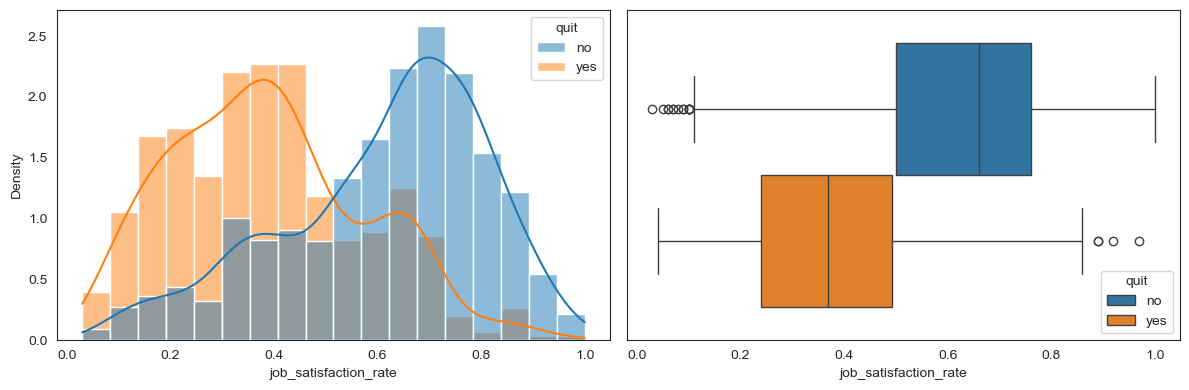

'Данные по уволившимся сотрудникам:'

count    564.000000
mean       0.387713
std        0.185784
min        0.040000
25%        0.240000
50%        0.370000
75%        0.492500
max        0.970000
Name: job_satisfaction_rate, dtype: float64

'Данные по не уволившимся сотрудникам:'

count    1436.000000
mean        0.612040
std         0.199367
min         0.030000
25%         0.500000
50%         0.660000
75%         0.760000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

In [688]:
num_plot_with_cat(test_full, ['job_satisfaction_rate'], 'quit', 'density', False)

Проверим на наличие значимой разницы средних значений признака "job_satisfaction_rate" для ушедших и оставшихся сотрудников

In [690]:
# зададим уровень значимости
alpha = .05

# проводим ttest для двух выборок, в качестве альтернативной используем двустороннюю гипотезу
results = st.ttest_ind(test_full.loc[test_full['quit'] == 'no', 'job_satisfaction_rate'],
                       test_full.loc[test_full['quit'] == 'yes', 'job_satisfaction_rate'])

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, средние значения выборок значимо отличаются')
else:
    print('Не отвергаем нулевую гипотезу, средние значения выборок значимо не отличаются')


p-value: 1.231122066517193e-104
Отвергаем нулевую гипотезу, средние значения выборок значимо отличаются


Рассчитаем корреляцию методом Phik

In [695]:
interval_cols = ['job_satisfaction_rate_pred']

test_full.loc[:, 'job_satisfaction_rate':'quit'].phik_matrix(interval_cols=interval_cols) 

,job_satisfaction_rate,quit
job_satisfaction_rate,1.000000,0.598562
quit,0.598562,1.000000


Из анализа распределения признака "job_satisfaction_rate" для ушедших и оставшихся сотрудников можно сделать следующие выводы:
- средние значения распределений уровня удовлетворённости сотрудника работой в компании для рассматриваемых двух категорий значимо отличаются друг от друга и составляют для уволившихся сотрудников - 0.39 и для оставшихся сотрудников - 0.66
- с ростом уровня удовлетворённости сотрудников работой в компании, снижается количество работников, уволившихся из компании
- коэффициент корреляции по матрице Phik составил 0.6, что говорит  к заметной  тесноте связи между уровнем удовлетворённости сотрудника работой в компании и его увольнением

## Добавление нового входного признака

Добавим `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

### Добавление нового входного признака в тестовую выборку

Возьмем подготовленный на предыдущем шаге датасет с тестовым данными `test_full`, исключим тестовый и добавим предсказанный `job_satisfaction_rate`. 

In [705]:
test_full_pred = test_full.drop(['job_satisfaction_rate'], axis=1)
test_full_pred['job_satisfaction_rate_pred'] = y_pred

### Добавление нового входного признака в тренировочную выборку

In [707]:
train_quit.head(1)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no


In [708]:
train_quit_pred = train_quit.set_index('id')

In [709]:
train_quit_pred['job_satisfaction_rate_pred'] = randomized_search.\
                                                predict(train_quit_pred.drop(['quit'], axis=1))
print(train_quit_pred.shape)
train_quit_pred.head(1)

(4000, 10)


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.605


## Подготовка данных

### Подготовка тренировочных данных

Проверим наличие неявных дубликатов в тренировочной выборке без учета признака `id`, т.е среди тех признаков, которые будут использоваться для обучения модели 

In [714]:
print(train_quit_pred.shape)
train_quit_pred.duplicated().sum()

(4000, 10)


1413

Имеем 1413 дубликатов, которые не несут новой информации, т.е. излишне забивают собой пространство данных, соответственно избыточно перегружают модель и возможно могут навредить обучению модели. Удалим дубликаты

In [716]:
train_quit_pred = train_quit_pred.drop_duplicates()
train_quit_pred.shape

(2587, 10)

### Корреляционный анализ

В связи с тем, что не все признаки распределены нормально, для корреляционного анализа используем матрицу Phik, которая устойчива к ненормальному распределению, позволяет учитывать нелинейные зависимости и работает с различными типами признаков

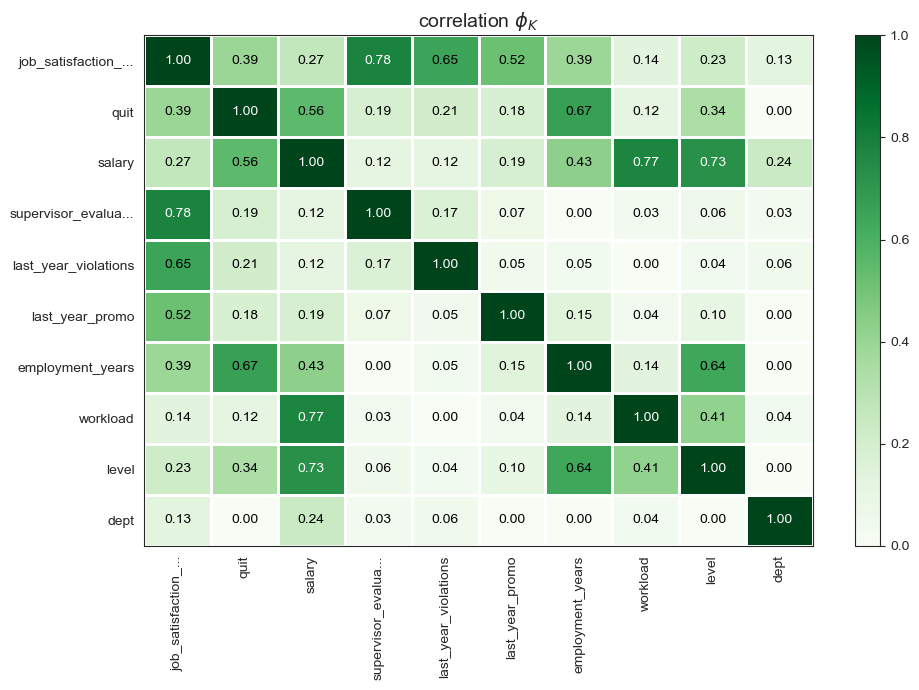

In [719]:
# построим матрицу корреляций Фи
interval_cols = ['employment_years', 'salary', 'supervisor_evaluation', 'job_satisfaction_rate_pred']

phik_overview = phik_matrix(train_quit_pred, interval_cols=interval_cols) 

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1,
    figsize=(10, 7)
) 

**Вывод:** из анализа матрицы видно, что мультиколлинеарность в данных отсутствует, при этом у целевого признака `quit` имеется:
- заметная теснота связи с признаками `salary` и `employment_years`

По другим признакам наблюдается:
- высокая теснота связи между параметрами `job_satisfaction_rate_pred` и `supervisor_evaluation`, `last_year_violations`
- высокая теснота связи между параметрами `salary` и `level`, `workload`

По остальным признакам наблюдается по большей части слабая связь или ее отсутствие    
Оставим весь набор признаков для прогнозирования события увольненения сотрудника из компании.

## Обучение модели

Для подбора модели будем использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров `RandomizedSearchCV`. Выбор лучшей модели будет осуществляться на основе заданной метрики — `ROC-AUC`

В рамках пайплайна используются следующие инструменты:    

для кодирования категориальных признаков:
- OneHotEncoder, OrdinalEncoder, LabelEncoder

для масштабирования количественных признаков:
- StandardScaler, MinMaxScaler, RobustScaler, без масштабирования

типы методов:
- DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression, SVC со своими настройками гиперпараметров

In [723]:
# подготовим тренировочную и тестовую выборки
X_train = train_quit_pred.drop(['quit'], axis=1)
y_train = train_quit_pred['quit']
X_test = test_full_pred.drop(['quit'], axis=1)
y_test = test_full_pred['quit']

# закодируем целевой признак с помощью LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
print('Порядок кодирования label_encoder:', label_encoder.classes_)

Порядок кодирования label_encoder: ['no' 'yes']


In [725]:
# создаём списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate_pred']

# создаём пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high'],
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', None)
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(3, 20),
        'models__min_samples_leaf': range(3, 10),
        'models__min_samples_split': range(3, 10),
        'models__max_features': range(5, 10)
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(5, 35),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='saga',
            penalty='l1',
            class_weight='balanced'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(probability=True, random_state=RANDOM_STATE)],
        'models__kernel': ['rbf','sigmoid', 'linear', 'poly'],
        'models__degree': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

randomized_search_quit = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=30
)
randomized_search_quit.fit(X_train, y_train)

display('Лучшая модель и её параметры:', randomized_search_quit.best_params_)
print ('Метрика ROC-AUC, полученная с помощью кросс-валидации:', randomized_search_quit.best_score_)

'Лучшая модель и её параметры:'

{'models__min_samples_split': 4,
 'models__min_samples_leaf': 4,
 'models__max_features': 9,
 'models__max_depth': 7,
 'models': DecisionTreeClassifier(random_state=42)}

Метрика ROC-AUC, полученная с помощью кросс-валидации: 0.904267370597571


In [730]:
# рассчитаем прогноз и метрику SMAPE на тестовых данных
y_test_proba = randomized_search_quit.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_proba)}')

Метрика ROC-AUC на тестовой выборке: 0.9224574764416523


Проверим лучшую модель на адекватность, путем сравнения качества её предсказаний с DummyClassifier

In [736]:
dummy_clf = DummyClassifier(strategy='prior')
dummy_clf.fit(X_train, y_train)

y_test_proba_dummy = dummy_clf.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC на тест выборке DummyClassifier:{roc_auc_score(y_test, y_test_proba_dummy)}')

Метрика ROC-AUC на тест выборке DummyClassifier:0.5


Качество предсказаний лучшей модели значительно выше результатов константной модели

In [738]:
result = pd.DataFrame(randomized_search_quit.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score').head())

,rank_test_score,param_models,mean_test_score,params
12,1,DecisionTreeClassifier(random_state=42),0.904267,"{'models__min_samples_split': 4, 'models__min_samples_leaf': 4, 'models__max_features': 9, 'models__max_depth': 7, 'models': DecisionTreeClassifier(random_state=42)}"
21,2,DecisionTreeClassifier(random_state=42),0.902087,"{'models__min_samples_split': 5, 'models__min_samples_leaf': 9, 'models__max_features': 9, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}"
16,3,DecisionTreeClassifier(random_state=42),0.898172,"{'models__min_samples_split': 8, 'models__min_samples_leaf': 7, 'models__max_features': 9, 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=42)}"
3,4,DecisionTreeClassifier(random_state=42),0.897796,"{'models__min_samples_split': 7, 'models__min_samples_leaf': 6, 'models__max_features': 9, 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=42)}"
9,5,DecisionTreeClassifier(random_state=42),0.896501,"{'models__min_samples_split': 9, 'models__min_samples_leaf': 7, 'models__max_features': 5, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}"


**Вывод:** **Моделью, показавшей наилучшие результаты** на кроссвалидационной выборке, стала `DecisionTreeClassifier` с параметрами: минимальное количество объектов в узле для разделения на классы - 4, минимальное количество объектов в одном листе - 4, максимальное количество используемых признаков - 9, глубина дерева - 7

Дерево решений оказалось лучшей моделью, в том числе по причине наличия нелинейных связей между параметрами, с которыми хуже справляются линейные модели, а также по причине наличия большего количества категориальных признаков, чем количественных, с чем также линейные модели или kNN справляются не очень хорошо, к таким данным больше подходит дерево решений.

## Анализ важности признаков

In [741]:
# извлечение лучшего пайплайна и модели
pipeline_best_task2 = randomized_search_quit.best_estimator_
model_best_task2 = pipeline_best_task2.named_steps['models']

# извлечем преобразованные названия столбцов и преобразуем X_train, X_test
feature_names = pipeline_best_task2.named_steps['preprocessor'].get_feature_names_out()

X_train_transformed = pipeline_best_task2.named_steps['preprocessor'].transform(X_train)
X_train_transformed = pd.DataFrame(X_train_transformed, columns=feature_names)
display(X_train_transformed.shape)

X_test_transformed = pipeline_best_task2.named_steps['preprocessor'].transform(X_test)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names)
X_test_transformed.shape

(2587, 12)

(2000, 12)

### График важности признаков для модели дерева решений

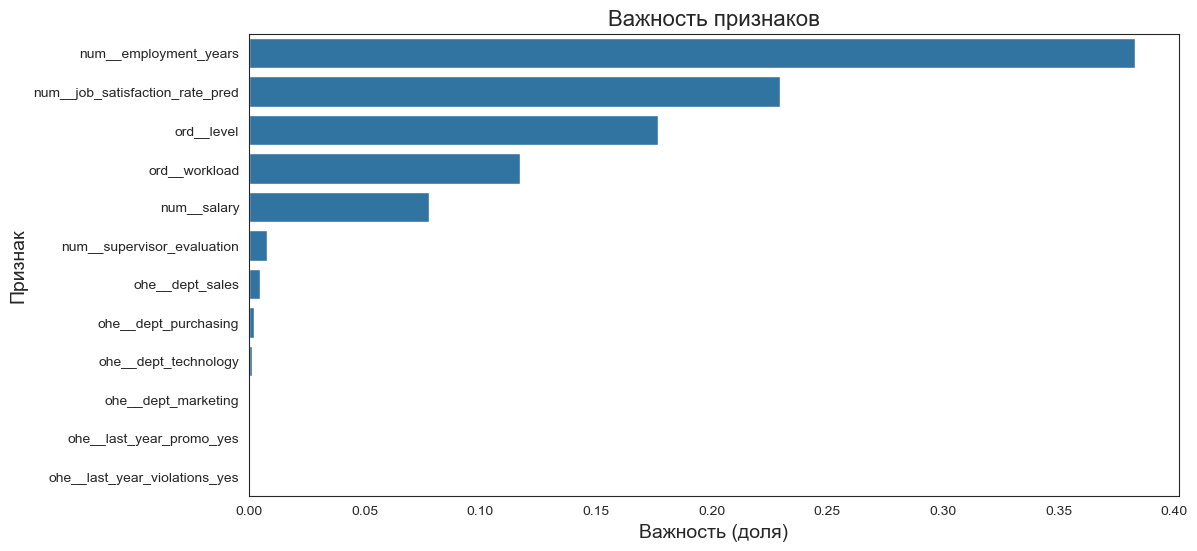

In [743]:
# формируем таблицу важности признаков и сортируем её
feature_importances = pd.DataFrame(
    {
        'Feature': X_train_transformed.columns,
        'Importance': model_best_task2.feature_importances_
    }).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))

ax = sns.barplot(data=feature_importances, x='Importance', y='Feature')

ax.set_title('Важность признаков', fontsize=16)
ax.set_xlabel('Важность (доля)', fontsize=14)
ax.set_ylabel('Признак', fontsize=14)

# отображаем график
plt.show()

Анализ важности признаков показывает, что наибольший вклад в прогноз вероятности увольнения сотрудника вносят:
- длительность работы в компании
- предсказанный уровень удовлетворённости сотрудника работой
- уровень занимаемой должности
- уровень загруженности сотрудника
- уровень зарплаты

### Оценка важности признаков на основе `Permutation importance`

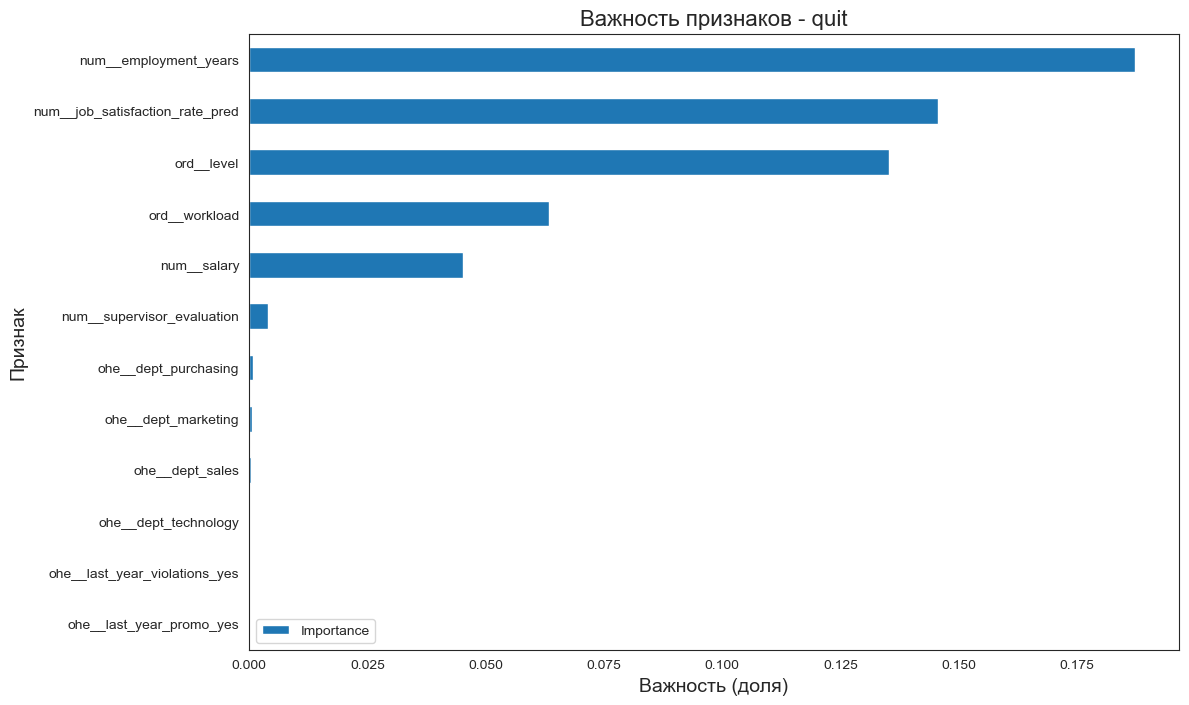

In [746]:
result = permutation_importance(model_best_task2, X_test_transformed, y_test,  scoring = 'roc_auc')

feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': result['importances_mean']})
feature_importance['Importance'] = abs(feature_importance['Importance'])
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(12, 8))
plt.title('Важность признаков - quit', fontsize=16)
plt.xlabel('Важность (доля)', fontsize=14)
plt.ylabel('Признак', fontsize=14);

Анализ результатов `permutation importance` показывает, что состав "пятерки" наиболее важных признаков сохраняется

### Оценка важности признаков на основе `SHAP`

Диаграмма `beeswarm`, отражающая вклад признаков в каждое предсказание модели.

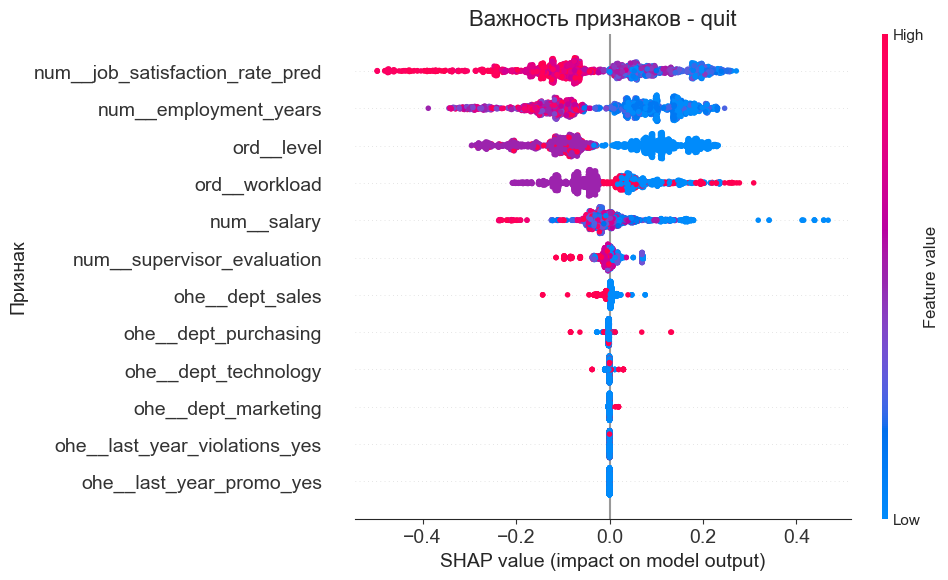

In [750]:
explainer = shap.TreeExplainer(model_best_task2, X_test_transformed)
shap_values = explainer(X_test_transformed)
shap.plots.beeswarm(shap_values[:,:,1], max_display=20, show=False)

fig, ax = plt.gcf(), plt.gca()

ax.tick_params(labelsize=14)
ax.set_xlabel("SHAP value (impact on model output)", fontsize=14)
ax.set_ylabel("Признак", fontsize=14)
ax.set_title('Важность признаков - quit', fontsize=16);

**Вывод:** на основе представленных графиков можно сделать следующие выводы о значимости признаков для прогнозирования:
1. признаки, мало значимые для модели:
- наименование департамента
- наличие повышения за последний год
- оценка качества работы сотрудника руководителем

2. признаки, сильнее всего влияющие на целевой признак:    
рост или увеличение уровня которых, приводят к увеличению вероятности увольнения сотрудника:
- уровень загруженности сотрудника

рост или увеличение уровня которых, приводят к уменьшению вероятности увольнения сотрудника:
- уровень удовлетворённости сотрудника работой
- длительность работы в компании
- уровень занимаемой должности
- уровень зарплаты    

## Общий вывод

**В рамках проекта была проведена:** предобработка данных, исследовательский анализ данных с необходимой визуализацией, статистический анализ признаков по типам, изучена взаимосвязь между признаками на основе корреляционного анализа.    
С целью прогноза уровня удовлетворённости сотрудника работой в компании обучены три модели, выбрана метрика и лучшая модель на основе данной метрики.    
Проведена оценка важности признаков для лучшей модели, сделаны необходимые выводы о значимости признаков.  
Составлен портрет «уволившегося сотрудника». Визуализированы и проведено сравнение распределения признака удовлетворённости сотрудника для ушедших и оставшихся сотрудников.    
С целью прогноза события увольнения сотрудника из компании обучены четыре модели, выбрана метрика и лучшая модель на основе данной метрики.    
Проведена оценка важности признаков для лучшей модели, сделаны необходимые выводы о значимости признаков.
_____________

**В целях задачи №1: предсказание уровня удовлетворённости сотрудника работой в компании**

**На этапе предобработки данных:** заменено некорректное наименование должности, явные дубликаты отсутствуют, неявные исключены из тренировочной выборки непосредственно перед обучением модели, выявленные в данных пропуски и знаки пробела заполнены на этапе пайплайна

**На этапе исследовательского анализа данных:** более глубоко исследованы количественные и категориальные данные с использованием графических инструментов, описаны характеристики данных

**На этапе корреляционного анализа признаков:** изучена взаимосвязь между всеми признаками на основе матрицы Phik. Анализ матрицы для тренировочной выборки показал, что мультиколлинеарность в данных отсутствует, при этом у целевого признака `job_satisfaction_rate` имеется:
- высокая теснота связи с признаком `supervisor_evaluation` и заметная теснота связи с признаком `last_year_violations`, таким образом оценка качества работы сотрудника, которую дал руководитель , и которая в т.ч. показывает отношение руководителя к работнику, а также факты нарушения сотрудником трудовой договора, имеют тесную связь с уровнем довлетворённости сотрудника

По другим признакам наблюдается:
- высокая теснота связи между параметрами `salary` c `workload` и `level`, а также умереннная с `employment_years`, т.е связь между уровнем зарплаты и загрузкой сотрудника на работе и уровнем его должности
- высокая теснота связи между параметрами `employment_years` и `level`, что также логично с точки зрения развития и роста сотрудника с течением отработанного времени.      
По остальным признакам наблюдается по большей части слабая связь или ее отсутствие

Анализ матрицы для тестовой выборки показал, что мультиколлинеарность в данных также отсутствует. Коэффициенты корреляции аналогичны соответствующим коэффициентам на тренировочной выборке, значения отличаются несущественно, разница в пределах 0.03. Ожидаем, что оценка модели, полученная на `test` выборке, будет корректной.

**На этапе подготовки данных:** была проведена проверка на наличие неявных дубликатов в тренировочной выборке без учета признака `id`, которые были устранены перед обучением модели 

**На этапе обучения и выбора лучшей модели:** с использованием пайплайнов обработаны количественные и категориальные признаки, пропуски, обучены 3 модели: `LinearRegression`, `Ridge`, `DecisionTreeClassifier`. Для каждой из моделей подобраны гиперпараметры. Для выбора лучшей модели использовалась метрика `SMAPE`, которая составила `15.29` на кроссвалидационной выборке и `13.45` на тестовой выборке.    
Моделью, показавшей наилучшие результаты на кроссвалидационной выборке, стала `DecisionTreeRegressor` с параметрами: минимальное количество объектов должно быть в узле, чтобы они разделились на классы - 4, минимальное количество объектов в одном листе - 3, глубина дерева - 17

**На этапе анализа важности признаков:** была проведена оценка важности признаков для лучшей модели с использованием:
- важности признаков для модели дерева решений
- важности признаков на основе `Permutation importance`
- важности признаков на основе `SHAP`    

Были сделаны следующие выводы о значимости признаков в целях прогнозирования удовлетворённости сотрудника работой:
1. признаки, мало значимые для модели:
- наименование департамента
- наличие повышения за последний год

2. признаки, сильнее всего влияющие на целевой признак:    
рост или увеличение уровня которых, приводят к увеличению удовлетворённости сотрудника работой:
- оценка качества работы сотрудника руководителем
- длительность работы в компании
- уровень зарплаты    

рост или увеличение уровня которых, приводят к снижению удовлетворённости сотрудника работой:
- уровень занимаемой должности
- факт нарушения сотрудником трудового договора за последний год
- уровень загруженности сотрудника
_________
**В целях задачи №2: предсказание увольнения сотрудника из компании**

**На этапе предобработки данных:** заменено некорректное наименование должности, явные дубликаты отсутствуют, неявные исключены из тренировочной выборки непосредственно перед обучением модели, выявленные в данных пропуски и знаки пробела заполнены на этапе пайплайна

**На этапе исследовательского анализа данных:** более глубоко исследованы количественные и категориальные данные с использованием графических инструментов, описаны характеристики данных.     
*Составлен портрет «уволившегося сотрудника»:*
- медианное значение зарплаты составляет около 23 000 руб., что на 50% ниже аналогичного значения по не уволимшимся сотрудникам
- более половины проработали до 1 года в компании, еще четверть уволилась в течении второго года работы, т.е сотрудники, которые возможно пришли набраться опыта или поняли, что компания им не подходит, а возможно и работодатель решил, что сотрудник, в силу разных причин не подходит компании, достаточно быстро увольняются. После отработки свыше трех лет факты увольнения уже достаточно редкие.
- почти половина имела оценку `3` качества работы, четверть имела оценку `4`
- около трети работала в отделе продаж, еще четверть в инженерном отделе. 
- почти 90% находилось на позиции `junior`, что соответствует анализу длительности работы в компании уволившегося сотрудника
- рабочая загрузка была на низком или среднем уровне - 46 и 43% соответственно
- не имел повышения за последний год
- 20% имели факт нарушения трудового договора за последний год, что почти в 2 раза больше, чем не по не уволившимся сотрудникам

*Из анализа распределения признака уровня удовлетворённости сотрудника работой в компании  для ушедших и оставшихся сотрудников можно сделать следующие выводы:*
- медианные значения распределений уровня удовлетворённости сотрудника работой в компании для рассматриваемых двух категорий смещены относительно друг друга и составляют для уволившихся сотрудников - 0.39 и для оставшихся сотрудников - 0.66
- с ростом уровня удовлетворённости сотрудников работой в компании, снижается количество работников, уволившихся из компании
- коэффициент корреляции по матрице Phik составил 0.6, что говорит  к заметной  тесноте связи между уровнем удовлетворённости сотрудника работой в компании и его увольнением

**На этапе корреляционного анализа признаков:** изучена взаимосвязь между всеми признаками на основе матрицы Phik. Анализ матрицы показал, что мультиколлинеарность в данных отсутствует, при этом у целевого признака `quit` имеется:
- заметная теснота связи с признаками `salary` и `employment_years`    
По другим признакам наблюдается:
- высокая теснота связи между параметрами `job_satisfaction_rate_pred` и `supervisor_evaluation`, `last_year_violations`
- высокая теснота связи между параметрами `salary` и `level`, `workload`    
По остальным признакам наблюдается по большей части слабая связь или ее отсутствие    

**На этапе подготовки данных:** была проведена проверка на наличие неявных дубликатов в тренировочной выборке без учета признака `id`, которые были устранены перед обучением модели 

**На этапе обучения и выбора лучшей модели:** с использованием пайплайнов обработаны количественные и категориальные признаки, пропуски, обучены 4 модели: `DecisionTreeClassifier`, `KNeighborsClassifier`, `LogisticRegression`, `SVC`. Для каждой из моделей подобраны гиперпараметры. Для выбора лучшей модели использовалась метрика `ROC-AUC`, которая составила `0.9` на кроссвалидационной выборке и `0.92` на тестовой выборке.    
Моделью, показавшей наилучшие результаты на кроссвалидационной выборке, стала `DecisionTreeClassifier` с параметрами: минимальное количество объектов в узле для разделения на классы - 4, минимальное количество объектов в одном листе - 4, максимальное количество используемых признаков - 9, глубина дерева - 7

**На этапе анализа важности признаков:** была проведена оценка важности признаков для лучшей модели с использованием:
- важности признаков для модели дерева решений
- важности признаков на основе `Permutation importance`
- важности признаков на основе `SHAP`    

Были сделаны следующие выводы о значимости признаков в целях прогнозирования вероятности увольнения сотрудника:
1. признаки, мало значимые для модели:
- наименование департамента
- наличие повышения за последний год
- оценка качества работы сотрудника руководителем

2. признаки, сильнее всего влияющие на целевой признак: 
рост или увеличение уровня которых, приводят к увеличению вероятности увольнения сотрудника:
- уровень загруженности сотрудника

рост или увеличение уровня которых, приводят к уменьшению вероятности увольнения сотрудника:
- уровень удовлетворённости сотрудника работой
- длительность работы в компании
- уровень занимаемой должности
- уровень зарплаты    

_________
На основе проведенной работы по проекту можно сделать следующие дополнительные рекомендации/предложения для бизнеса:     
*В целях повышения уровня удовлетворённости сотрудника работой в компании:*
- проводить периодически оценку качества работы сотрудника непосредственным руководителем с целью своевременного отмечания и возможного поощренрия полезных сотрудников, так как этот параметр оказался наиболее важным с точки зрения влияния на уровень удовлетворённости сотрудника работой
- своевременно повышать уровень зарплаты с целью сохранения мотивации и удержания нужных сотрудников
- обращать повышенное внимание на сотрудников высокого уровня,  также по возможности поддерживать рыночный уровень зарплаты или выяснять существующими методами HR индивидуально мотивацию каждого из таких сотрудников и действовать в соответствии с ней, возможно смена задач, гибридный режим работы и пр.
- мониторить факты нарушения сотрудником трудового договора за последний год, их рост говорит о снижении уровня удовлетворённости сотрудника
- отслеживать уровень загруженности сотрудника, не допускать чрезмерных перегрузок

*В целях снижения вероятности увольнения сотрудника из компании:*
- поддерживать уровнень удовлетворённости сотрудника на высоком уровне путем действий, перечесленных в предыдущем блоке
- своевременно повышать уровень зарплаты работнику
- обеспечивать карьерный рост в компании как по уровню должности, так и горизонтально, выясняя предпочтения сотрудника
- также мониторить уровень загруженности сотрудника, не допускать чрезмерных перегрузок
- выделить отдельную "группу риска", для которой имеется повышенный уровень вероятности увольнения сотрудников, взять ее на отдельный контроль и своевременно применять к ней все необходимые вышеизложенные действия:
  - сотрудники с длительностью работы в компании до 2 лет
  - средняя оценка `3` качества работы сотрудника, которую дал руководитель
  - значение зарплаты составляет около 23 000 руб.
  - уровень должности `junior`
  - отсутствие повышения за последний год